# Load Packages

In [59]:
import numpy as np
from pathlib import Path
import pandas as pd
import torch
import os
import pickle
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
plt.rcParams['font.family'] = 'Times New Roman'

# Load training results.

### Load results from CLIP-HBA-Behavior fine-tuning

In [61]:
# specify path to the results
cliphba_res_path = Path('/home/wallacelab/teba/marren/temporal_dynamics_of_human_alignment/training_results/training_res_20250916_172925.csv')

# read in the csv
cliphba_training_res = pd.read_csv(cliphba_res_path)

# print the first 20 rows
print(cliphba_training_res.head(10))

   epoch  train_loss   test_loss  behavioral_rsa_rho  behavioral_rsa_p_value
0      1  143.751595  115.315276            0.457751            1.666298e-59
1      2   99.242973   91.896147            0.421845            6.852262e-50
2      3   88.322808   84.964224            0.429777            6.463552e-52
3      4   82.917093   80.390052            0.440350            1.059977e-54
4      5   78.495574   76.284173            0.461701            1.236095e-60
5      6   74.905132   73.262793            0.509848            1.156426e-75
6      7   72.226379   70.678066            0.566353            1.129755e-96
7      8   69.511314   67.750846            0.621591           1.482924e-121
8      9   66.146474   63.975467            0.656572           4.456361e-140
9     10   61.777572   59.086500            0.669874           8.654169e-148


# Process fMRI RDMs.

### Load fMRI RDMs for VA-1, VA-2, VA-3, left LOC, and right LOC.

In [67]:
# Load all the files from the fmri_path directory that contain the word 'va-1', or 'va-2', or 'va-3'
fmri_path = Path('../../THINGS_fMRI/all_rdm')
fmri_files = list(fmri_path.glob("*va-1_*")) + list(fmri_path.glob("*va-2_*")) + list(fmri_path.glob("*va-3_*")) + list(fmri_path.glob("*lLOC*")) + list(fmri_path.glob("*rLOC*"))

# create a dictionary to store the fMRI RDMs
fmri_rdms = {}

for file in fmri_files:
    # extract the subject number from the file name
    subject_number = file.stem.split('_')[0].split('-')[1]
    print(subject_number)
    # extract the roi from the file name
    # This pattern is looking for the ROI name as the second element after splitting the filename (without extension) by underscores.
    if 'va' in file.stem:
        roi = file.stem.split('_')[2]
    else:
        roi = file.stem.split('_')[1]
    print(roi)
    fmri_rdm = np.load(file)
    print(fmri_rdm.shape)
    # store the fMRI RDM in the dictionary
    fmri_rdms[subject_number + '_' + roi] = fmri_rdm

# # print the first 5x5 of every fMRI RDM in the dictionary
for key in fmri_rdms:
    print(key)
    print(fmri_rdms[key][:5, :5])

02
va-1
(720, 720)
03
va-1
(720, 720)
01
va-1
(720, 720)
01
va-2
(720, 720)
02
va-2
(720, 720)
03
va-2
(720, 720)
03
va-3
(720, 720)
01
va-3
(720, 720)
02
va-3
(720, 720)
02
lLOC
(720, 720)
03
lLOC
(720, 720)
01
lLOC
(720, 720)
01
rLOC
(720, 720)
02
rLOC
(720, 720)
03
rLOC
(720, 720)
02_va-1
[[0.         0.5        0.45833333 0.58333333 0.625     ]
 [0.5        0.         0.625      0.70833333 0.875     ]
 [0.45833333 0.625      0.         0.58333333 0.375     ]
 [0.58333333 0.70833333 0.58333333 0.         0.54166667]
 [0.625      0.875      0.375      0.54166667 0.        ]]
03_va-1
[[0.         0.625      0.75       0.75       0.41666667]
 [0.625      0.         0.66666667 0.58333333 0.41666667]
 [0.75       0.66666667 0.         0.375      0.58333333]
 [0.75       0.58333333 0.375      0.         0.58333333]
 [0.41666667 0.41666667 0.58333333 0.58333333 0.        ]]
01_va-1
[[0.         0.75       0.41666667 0.66666667 0.54166667]
 [0.75       0.         0.70833333 0.75       0.75 

### Get the variable names for our five ROIs.

In [68]:
fmri_rdms_rois = list(set([key.split('_')[1] for key in fmri_rdms.keys()]))

print(fmri_rdms_rois)

for roi in fmri_rdms_rois:
    # Create a dictionary of RDMs for the current ROI, using the ROI name in the variable name
    roi_rdms_varname = f"{roi}_rdms"
    locals()[roi_rdms_varname] = {k: v for k, v in fmri_rdms.items() if roi in k}

    print(roi_rdms_varname)

['va-2', 'rLOC', 'va-3', 'va-1', 'lLOC']
va-2_rdms
rLOC_rdms
va-3_rdms
va-1_rdms
lLOC_rdms


### Load the concept index for the fMRI RDMs.

In [69]:
# Loading the concept index for the fMRI RDM

concept_index = np.load('./concept_indices/sub-01_LOC_concept_index.npy')

print(concept_index)

['acorn' 'airbag' 'aircraft_carrier' 'airplane' 'alligator' 'aloe' 'altar'
 'aluminum_foil' 'anchor' 'anklet' 'ant' 'anteater' 'antelope' 'antenna'
 'anvil' 'apple' 'applesauce' 'artichoke' 'ashtray' 'asparagus' 'avocado'
 'axe' 'baby' 'backpack' 'bag' 'bagel' 'ball' 'balloon' 'bamboo' 'banana'
 'banana_split' 'bandage' 'banner' 'barnacle' 'barrel' 'basket' 'bassinet'
 'battery' 'beachball' 'beaker' 'bean' 'bear' 'beaver' 'bed' 'bee' 'beer'
 'beet' 'beetle' 'bell' 'bench' 'bib' 'bike' 'binoculars' 'bird'
 'birdcage' 'birdhouse' 'bison' 'blackberry' 'blanket' 'blazer' 'blender'
 'blimp' 'blind' 'blowtorch' 'blueberry' 'boa' 'boar' 'boat' 'bobsled'
 'bolt' 'book' 'boot' 'bottle' 'bow2' 'bowl' 'boxer_shorts'
 'boxing_gloves' 'boy' 'brace' 'bracelet2' 'bracket' 'bread' 'breadbox'
 'breadstick' 'broccoli' 'broom' 'brownie' 'brush' 'bubble' 'bucket'
 'buggy' 'bulldozer' 'bullet' 'bumper' 'bungee' 'bunkbed' 'burner'
 'burrito' 'bus' 'butterfly' 'cabbage' 'cactus' 'cage' 'cake' 'calculator'
 '

### Read in the Stimulus Metadata file for each subject to ensure that all subjects were shown the same 8640 images making up the 720 concepts during fMRI trials.

In [70]:
# I want to read in the Stimulus Metadata file for each subject

# Load the Stimulus Metadata file for each subject
# I want to sort the Stimulus Metadata file by the 'concept' column
# Yes, you can do this safely in one line:
sub_01_stimulus_metadata = pd.read_csv('sub-01_StimulusMetadata_train_only.csv').sort_values(by='concept').sort_values(by='stimulus')

# print the first 20 rows of the Stimulus Metadata file
#print(sub_01_stimulus_metadata.head(20))

sub_02_stimulus_metadata = pd.read_csv('sub-02_StimulusMetadata_train_only.csv').sort_values(by='concept').sort_values(by='stimulus')

#print(sub_02_stimulus_metadata.head(20))

sub_03_stimulus_metadata = pd.read_csv('sub-03_StimulusMetadata_train_only.csv').sort_values(by='concept').sort_values(by='stimulus')

#print(sub_03_stimulus_metadata.head(20))

# I want to test whether the stimulus column is exactly the same across all three subjects
# FIXED: Use reset_index(drop=True) to compare only values, not indices
print("Comparing stimulus columns (values only):")
print(sub_01_stimulus_metadata['stimulus'].reset_index(drop=True).equals(sub_02_stimulus_metadata['stimulus'].reset_index(drop=True)))
print(sub_01_stimulus_metadata['stimulus'].reset_index(drop=True).equals(sub_03_stimulus_metadata['stimulus'].reset_index(drop=True)))
print(sub_02_stimulus_metadata['stimulus'].reset_index(drop=True).equals(sub_03_stimulus_metadata['stimulus'].reset_index(drop=True)))

# Find and print rows where the 'stimulus' column differs across the three subjects

stim_01 = sub_01_stimulus_metadata['stimulus'].reset_index(drop=True)
stim_02 = sub_02_stimulus_metadata['stimulus'].reset_index(drop=True)
stim_03 = sub_03_stimulus_metadata['stimulus'].reset_index(drop=True)

# Find indices where any pair is not equal
diff_mask = ~((stim_01 == stim_02) & (stim_01 == stim_03) & (stim_02 == stim_03))

# Print the differing rows
if diff_mask.any():
    print("Rows where 'stimulus' column differs across subjects:")
    diff_df = pd.DataFrame({
        'row': stim_01.index[diff_mask],
        'sub_01_stimulus': stim_01[diff_mask].values,
        'sub_02_stimulus': stim_02[diff_mask].values,
        'sub_03_stimulus': stim_03[diff_mask].values
    })
    print(diff_df)
else:
    print("No differences found in the 'stimulus' column across the three subjects.")

Comparing stimulus columns (values only):
True
True
True
No differences found in the 'stimulus' column across the three subjects.


### We can safely say that all three subjects were shown the same 12 images across all 720 object concepts. 

### Calculate the average concept RDM for each ROI across subjects.

In [71]:
# Create averaged upper triangle vectors for all ROIs
# First, identify all unique ROIs from the fmri_rdms dictionary
rois = set()
for key in fmri_rdms.keys():
    roi = key.split('_')[1]  # Extract ROI from key like '01_lLOC' -> 'lLOC'
    rois.add(roi)

print("Available ROIs:", sorted(rois))

# Create a dictionary to store averaged upper triangle vectors for each ROI
roi_average_upper_triangles = {}

# Get upper triangular indices (same for all RDMs since they're all 720x720)
upper_tri_indices = np.triu_indices_from(fmri_rdms[list(fmri_rdms.keys())[0]], k=1)

for roi in sorted(rois):
    print(f"\nProcessing ROI: {roi}")
    
    # Filter RDMs for this specific ROI
    roi_rdms = {k: v for k, v in fmri_rdms.items() if roi in k}
    print(f"Found {len(roi_rdms)} RDMs for {roi}")
    
    # Extract upper triangular elements for each RDM
    roi_rdms_upper = {}
    for key in roi_rdms:
        roi_rdms_upper[key] = roi_rdms[key][upper_tri_indices]
    
    # Stack the vectors into a single array
    roi_rdms_upper_array = np.stack(list(roi_rdms_upper.values()))
    print(f"Stacked array shape: {roi_rdms_upper_array.shape}")
    
    # Calculate the average across subjects
    # axis=0 means we are taking the mean down the rows (i.e., column-wise), so for each position in the upper triangle vector, we average across all subjects' RDMs
    roi_average_upper_triangle = np.mean(roi_rdms_upper_array, axis=0)
    print(f"Average vector shape: {roi_average_upper_triangle.shape}")
    
    # Store in the dictionary
    roi_average_upper_triangles[roi] = roi_average_upper_triangle
    
    # Print first 5 values as a sanity check
    print(f"First 5 values for {roi}: {roi_average_upper_triangle[:5]}")

print(f"\nCreated averaged upper triangle vectors for {len(roi_average_upper_triangles)} ROIs:")
for roi in roi_average_upper_triangles:
    print(f"  {roi}: shape {roi_average_upper_triangles[roi].shape}")

Available ROIs: ['lLOC', 'rLOC', 'va-1', 'va-2', 'va-3']

Processing ROI: lLOC
Found 3 RDMs for lLOC
Stacked array shape: (3, 258840)
Average vector shape: (258840,)
First 5 values for lLOC: [0.63888889 0.55555556 0.625      0.61111111 0.54166667]

Processing ROI: rLOC
Found 3 RDMs for rLOC
Stacked array shape: (3, 258840)
Average vector shape: (258840,)
First 5 values for rLOC: [0.68055556 0.51388889 0.69444444 0.56944444 0.54166667]

Processing ROI: va-1
Found 3 RDMs for va-1
Stacked array shape: (3, 258840)
Average vector shape: (258840,)
First 5 values for va-1: [0.625      0.54166667 0.66666667 0.52777778 0.48611111]

Processing ROI: va-2
Found 3 RDMs for va-2
Stacked array shape: (3, 258840)
Average vector shape: (258840,)
First 5 values for va-2: [0.61111111 0.54166667 0.625      0.43055556 0.43055556]

Processing ROI: va-3
Found 3 RDMs for va-3
Stacked array shape: (3, 258840)
Average vector shape: (258840,)
First 5 values for va-3: [0.59722222 0.52777778 0.66666667 0.5        

### Average the fMRI activity between left and right LOC.

In [72]:
roi_average_upper_triangles['LOC'] = np.mean(
    np.stack([roi_average_upper_triangles['lLOC'], roi_average_upper_triangles['rLOC']]), axis=0
)

print(roi_average_upper_triangles['LOC'].shape)

print(roi_average_upper_triangles['rLOC'].shape)

print(roi_average_upper_triangles.keys())

# remove the lLOC and rLOC keys
roi_average_upper_triangles.pop('lLOC')
roi_average_upper_triangles.pop('rLOC')

print(roi_average_upper_triangles.keys())

(258840,)
(258840,)
dict_keys(['lLOC', 'rLOC', 'va-1', 'va-2', 'va-3', 'LOC'])
dict_keys(['va-1', 'va-2', 'va-3', 'LOC'])


# Create feature-reweighting functions.

### Convert the vectors of fMRI RDMs averaged across subjects for each ROI back to 720x720 RDMs to ensure proper formatting for analysis.

In [73]:
# Convert upper triangular vectors back to 720x720 RDMs (CORRECTED VERSION)
# This reconstructs the full RDM matrices from the upper triangular elements

# Dictionary to store reconstructed RDMs
roi_reconstructed_rdms = {}

print("Reconstructing 720x720 RDMs from upper triangular vectors (CORRECTED)...")
print("=" * 70)

# Get the upper triangular indices (same as used before)
upper_tri_indices = np.triu_indices(720, k=1)  # 720x720 matrix, k=1 excludes diagonal

print(f"Upper triangular indices shape: {upper_tri_indices[0].shape}")
print(f"Number of upper triangular elements: {len(upper_tri_indices[0])}")
print(f"Expected vector length: {len(upper_tri_indices[0])}")

# Loop through each ROI
for roi in sorted(roi_average_upper_triangles.keys()):
    print(f"\nProcessing ROI: {roi}")
    
    # Get the upper triangular vector
    upper_tri_vector = roi_average_upper_triangles[roi]
    print(f"  Upper triangular vector shape: {upper_tri_vector.shape}")
    print(f"  Vector length: {len(upper_tri_vector)}")
    
    # Verify the vector length matches expected
    expected_length = len(upper_tri_indices[0])
    if len(upper_tri_vector) != expected_length:
        print(f"  ⚠ Warning: Vector length {len(upper_tri_vector)} doesn't match expected {expected_length}")
    else:
        print(f"  ✓ Vector length matches expected")
    
    # Create empty RDM matrix
    rdm = np.zeros((720, 720))
    
    # Fill the upper triangular part
    rdm[upper_tri_indices] = upper_tri_vector
    
    # Fill the lower triangular part (RDM is symmetric) - CORRECTED METHOD
    # Use transpose to ensure perfect symmetry
    rdm = rdm + rdm.T
    
    # Ensure diagonal is zero
    np.fill_diagonal(rdm, 0)
    
    # Store the reconstructed RDM
    roi_reconstructed_rdms[roi] = rdm
    
    print(f"  Reconstructed RDM shape: {rdm.shape}")
    print(f"  RDM is symmetric: {np.allclose(rdm, rdm.T)}")
    print(f"  Diagonal is zero: {np.all(np.diag(rdm) == 0)}")
    print(f"  Min value: {np.min(rdm):.4f}")
    print(f"  Max value: {np.max(rdm):.4f}")
    print(f"  Mean value: {np.mean(rdm):.4f}")

print(f"\nSuccessfully reconstructed RDMs for {len(roi_reconstructed_rdms)} ROIs")
print(f"Available ROIs: {sorted(roi_reconstructed_rdms.keys())}")

# Verify reconstruction by comparing with original data
print(f"\nReconstruction verification:")
for roi in sorted(roi_reconstructed_rdms.keys()):
    reconstructed_rdm = roi_reconstructed_rdms[roi]
    original_vector = roi_average_upper_triangles[roi]
    
    # Extract upper triangular from reconstructed RDM
    reconstructed_vector = reconstructed_rdm[upper_tri_indices]
    
    # Check if they match
    vectors_match = np.allclose(original_vector, reconstructed_vector)
    print(f"  {roi}: Vectors match = {vectors_match}")
    
    if not vectors_match:
        diff = np.abs(original_vector - reconstructed_vector)
        print(f"    Max difference: {np.max(diff):.10f}")
        print(f"    Mean difference: {np.mean(diff):.10f}")

# Show how to access the reconstructed RDMs
print(f"\nExample usage:")
first_roi = sorted(roi_reconstructed_rdms.keys())[0]
print(f"  roi_reconstructed_rdms['{first_roi}']  # 720x720 RDM for {first_roi}")
print(f"  roi_reconstructed_rdms['{first_roi}'][:5, :5]  # First 5x5 of the RDM")

# Show a sample of the reconstructed RDM
sample_roi = sorted(roi_reconstructed_rdms.keys())[0]
sample_rdm = roi_reconstructed_rdms[sample_roi]
print(f"\nSample RDM ({sample_roi}) - first 5x5:")
print(sample_rdm[:5, :5])

Reconstructing 720x720 RDMs from upper triangular vectors (CORRECTED)...
Upper triangular indices shape: (258840,)
Number of upper triangular elements: 258840
Expected vector length: 258840

Processing ROI: LOC
  Upper triangular vector shape: (258840,)
  Vector length: 258840
  ✓ Vector length matches expected
  Reconstructed RDM shape: (720, 720)
  RDM is symmetric: True
  Diagonal is zero: True
  Min value: 0.0000
  Max value: 0.9167
  Mean value: 0.6098

Processing ROI: va-1
  Upper triangular vector shape: (258840,)
  Vector length: 258840
  ✓ Vector length matches expected
  Reconstructed RDM shape: (720, 720)
  RDM is symmetric: True
  Diagonal is zero: True
  Min value: 0.0000
  Max value: 0.9306
  Mean value: 0.5621

Processing ROI: va-2
  Upper triangular vector shape: (258840,)
  Vector length: 258840
  ✓ Vector length matches expected
  Reconstructed RDM shape: (720, 720)
  RDM is symmetric: True
  Diagonal is zero: True
  Min value: 0.0000
  Max value: 0.9444
  Mean value:

### Define a function that uses ridge regression to generate weights for combining the 14 layer-level RDMs to predict a single neural RDM.

In [74]:
def ridge_reweighting_single_rdm(
    model_rdms,  # Shape: [L, N, N]
    neural_rdm,   # Shape: [N, N] - single RDM
    alpha_candidates=None,
    cv_folds=5,
    objective='spearman'
):
    """
    Compute ridge weights combining layer model RDMs to predict a single neural RDM.
    
    Args:
        model_rdms: Model RDMs of shape [L, N, N]
        neural_rdm: Single neural RDM of shape [N, N]
        alpha_candidates: List of alpha values to test
        cv_folds: Number of cross-validation folds
        objective: 'spearman' or 'ridgecv'
        
    Returns:
        weights: Ridge weights of shape [L] - one weight per layer
        best_alpha: Best alpha value found
        cv_score: Cross-validation score
    """

    L, N, _ = model_rdms.shape
    
    # Build feature matrix X = upper-tri of each layer RDM -> [n_pairs, L]
    triu = torch.triu_indices(N, N, offset=1)
    n_pairs = triu.shape[1]
    X = np.zeros((n_pairs, L), dtype=np.float32)
    
    for l in range(L):
        rdm_l = model_rdms[l]
        X[:, l] = rdm_l[triu[0], triu[1]].astype(np.float32)
    
    # Extract target vector from neural RDM
    if isinstance(neural_rdm, torch.Tensor):
        y = neural_rdm[triu[0], triu[1]].cpu().numpy().astype(np.float32)
    else:
        y = neural_rdm[triu[0], triu[1]].astype(np.float32)
    
    alpha_candidates = alpha_candidates if alpha_candidates is not None else [1e-3, 1e-2, 1e-1, 1.0, 1e1, 1e2, 1e3]
    
    # Cross-validation to find best alpha
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=0)
    best_alpha = None
    best_score = -np.inf
    
    print(f"Cross-validating {len(alpha_candidates)} alpha values with {cv_folds} folds...")

    for alpha in tqdm(alpha_candidates, desc="Cross-validating alphas"):
        fold_scores = []
        
        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]
            
            if objective == 'spearman':
                # Rank-transform targets and center
                y_tr_rank = stats.rankdata(y_tr).astype(np.float32)
                y_tr_rank -= y_tr_rank.mean()
                
                model = Ridge(alpha=alpha, fit_intercept=False)
                model.fit(X_tr, y_tr_rank)
                y_val_pred = X_val @ model.coef_.astype(np.float32)
                
                rho, _ = stats.spearmanr(y_val_pred, y_val)
                if np.isnan(rho):
                    rho = 0.0
                fold_scores.append(float(rho))

            else:  # ridgecv objective
                # Center targets
                y_tr_centered = y_tr - y_tr.mean()
                y_val_centered = y_val - y_val.mean()
                
                model = Ridge(alpha=alpha, fit_intercept=False)
                model.fit(X_tr, y_tr_centered)
                y_val_pred = X_val @ model.coef_.astype(np.float32)
                
                # R² score
                ss_res = np.sum((y_val_centered - y_val_pred)**2)
                ss_tot = np.sum((y_val_centered - y_val_centered.mean())**2) + 1e-12
                r2 = 1.0 - ss_res/ss_tot
                fold_scores.append(float(r2))
        
        mean_score = float(np.mean(fold_scores))
        if mean_score > best_score:
            best_score = mean_score
            best_alpha = float(alpha)

    # Refit on full data with best alpha
    if objective == 'spearman':
        y_rank = stats.rankdata(y).astype(np.float32)
        y_rank -= y_rank.mean()
        final_model = Ridge(alpha=best_alpha, fit_intercept=False)
        final_model.fit(X, y_rank)
        weights = torch.from_numpy(final_model.coef_.astype(np.float32))
    else:
        y_centered = y - y.mean()
        final_model = Ridge(alpha=best_alpha, fit_intercept=False)
        final_model.fit(X, y_centered)
        weights = torch.from_numpy(final_model.coef_.astype(np.float32))
    
    print(f"Best alpha: {best_alpha}")
    print(f"CV score: {best_score:.4f}")
    
    return weights, best_alpha, best_score

### Define a function that computes a feature-reweighted model RDM from the ridge weights.

In [75]:
def compute_reweighted_predictor(
    model_rdms,  # Shape: [L, N, N]
    weights     # Shape: [L] - ridge weights
):
    """
    Compute the reweighted predictor RDM by combining model RDMs with ridge weights.
    
    Args:
        model_rdms: Model RDMs of shape [L, N, N]
        weights: Ridge weights of shape [L]
        
    Returns:
        reweighted_rdm: Combined RDM of shape [N, N]
    """
    L, N, _ = model_rdms.shape
    
    # Convert weights to numpy if needed
    if isinstance(weights, torch.Tensor):
        weights = weights.cpu().numpy()
    
    # Initialize reweighted RDM
    reweighted_rdm = np.zeros((N, N), dtype=np.float32)
    
    # Weighted combination of model RDMs
    for l in range(L):
        reweighted_rdm += weights[l] * model_rdms[l]
    
    # Ensure symmetry (in case of numerical errors)
    reweighted_rdm = (reweighted_rdm + reweighted_rdm.T) / 2
    
    # Set diagonal to 0 (RDMs should have 0 on diagonal)
    np.fill_diagonal(reweighted_rdm, 0)

    return reweighted_rdm

### Define a function that will run the RDM feature-reweighting analysis.

In [76]:
def run_single_rdm_analysis(
    model_rdms,      # Shape: [L, N, N]
    neural_rdm,      # Shape: [N, N]
    alpha_candidates=None,
    cv_folds=5,
    objective='spearman'
):
    """
    Complete pipeline for single RDM ridge regression analysis.
    
    Returns:
        weights: Ridge weights [L]
        best_alpha: Best alpha value
        cv_score: Cross-validation score
        reweighted_rdm: Predicted RDM [N, N]
        correlation: Correlation between predicted and actual RDM
    """
    print("Single RDM Ridge Regression Analysis")
    print("=" * 50)
    print(f"Model RDMs shape: {model_rdms.shape}")
    print(f"Neural RDM shape: {neural_rdm.shape}")
    print(f"Objective: {objective}")
    print(f"CV folds: {cv_folds}")
    
    # Compute ridge weights
    weights, best_alpha, cv_score = ridge_reweighting_single_rdm(
        model_rdms, neural_rdm, alpha_candidates, cv_folds, objective
    )
    
    # Compute reweighted predictor
    reweighted_rdm = compute_reweighted_predictor(model_rdms, weights)

    # Compute correlation between predicted and actual
    # Extract upper triangular parts for correlation
    triu = np.triu_indices(neural_rdm.shape[0], k=1)
    neural_flat = neural_rdm[triu]
    predicted_flat = reweighted_rdm[triu]
    
    if objective == 'spearman':
        correlation, _ = stats.spearmanr(neural_flat, predicted_flat)
    else:
        correlation, _ = stats.pearsonr(neural_flat, predicted_flat)
    
    print(f"\nResults:")
    print(f"Best alpha: {best_alpha}")
    print(f"CV score: {cv_score:.4f}")
    print(f"Final correlation: {correlation:.4f}")
    print(f"Weights: {weights.numpy()}")
    
    return {
        'weights': weights,
        'best_alpha': best_alpha,
        'cv_score': cv_score,
        'reweighted_rdm': reweighted_rdm,
        'correlation': correlation
    }

# Process Inference Data

## CLIP-HBA Behavior Inference

### Load the CLIP-HBA-behavior last-layer embeddings from all 8640 images that make up the 720 concepts (12 images per concept). For every concept, we'll average the embeddings from the 12 images to get the concept embedding.

In [129]:
# Load the CLIP-HBA-behavior last-layer embeddings from all 8,640 images that make up the 720 concepts
hba_embeddings_path = Path('/home/wallacelab/teba/marren/temporal_dynamics_of_human_alignment/inference_results/20250916_172925_720_concepts')

# list the files in the concept_embeddings_path 
hba_embeddings_files = os.listdir(hba_embeddings_path)
hba_embeddings_files = sorted(
    hba_embeddings_files, 
    key=lambda f: int(f.split('_')[3].replace('epoch', '').replace('.csv', ''))
)

# print the first 20 files
print(hba_embeddings_files[:20])

# Create a dictionary to store concept embeddings for each epoch
hba_concept_embeddings_dict = {}

for file in hba_embeddings_files:
    epoch = file.split('_')[3].replace('epoch', '').replace('.csv', '')
    print(epoch)
    hba_embeddings = pd.read_csv(os.path.join(hba_embeddings_path, file))
    concept_name = []
    concept_embeddings = []
    # group by the 'concept' column and average the embeddings
    for concept in concept_index:
        hba_embeddings_subset = hba_embeddings[hba_embeddings['concept'] == concept].iloc[:, -66:]
        # average the embeddings
        hba_concept_embedding = hba_embeddings_subset.mean()
        concept_name.append(concept)
        concept_embeddings.append(hba_concept_embedding)
    # Create a DataFrame for this epoch
    hba_concept_embeddings = pd.DataFrame(concept_embeddings)
    hba_concept_embeddings['concept'] = concept_name
    hba_concept_embeddings = hba_concept_embeddings[['concept'] + [col for col in hba_concept_embeddings if col != 'concept']]
    # Store in the dictionary
    hba_concept_embeddings_dict[epoch] = hba_concept_embeddings

print(hba_concept_embeddings_dict)

['720_concept_embeddings_epoch1.csv', '720_concept_embeddings_epoch2.csv', '720_concept_embeddings_epoch3.csv', '720_concept_embeddings_epoch4.csv', '720_concept_embeddings_epoch5.csv', '720_concept_embeddings_epoch6.csv', '720_concept_embeddings_epoch7.csv', '720_concept_embeddings_epoch8.csv', '720_concept_embeddings_epoch9.csv', '720_concept_embeddings_epoch10.csv', '720_concept_embeddings_epoch11.csv', '720_concept_embeddings_epoch12.csv', '720_concept_embeddings_epoch13.csv', '720_concept_embeddings_epoch14.csv', '720_concept_embeddings_epoch15.csv', '720_concept_embeddings_epoch16.csv', '720_concept_embeddings_epoch17.csv', '720_concept_embeddings_epoch18.csv', '720_concept_embeddings_epoch19.csv', '720_concept_embeddings_epoch20.csv']
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86

### Now we have an HBA embeddings dictionary, which holds the 720 concept embeddings for every epoch of CLIP-HBA-behavior fine-tuning. We will use this dictionary to create a concept RDM for the model at every epoch.

In [130]:
hba_concept_rdms_dict = {}

for epoch in hba_concept_embeddings_dict:
    print(epoch)
    # take the last 66 columns of the dataframe in the key and convert to numpy array
    hba_concept_embeddings = hba_concept_embeddings_dict[epoch].iloc[:, -66:].to_numpy()
    print(hba_concept_embeddings.shape)
    # create a concept RDM from the concept embeddings and add it to a dictionary
    concept_rdm = 1 - cosine_similarity(hba_concept_embeddings)
    np.fill_diagonal(concept_rdm, 0)
    print(concept_rdm.shape)
    upper_tri_indices = np.triu_indices_from(concept_rdm, k=1)
    hba_concept_rdms_dict[epoch] = concept_rdm[upper_tri_indices]
    print(hba_concept_rdms_dict[epoch].shape)

print(hba_concept_rdms_dict.keys())

1
(720, 66)
(720, 720)
(258840,)
2
(720, 66)
(720, 720)
(258840,)
3
(720, 66)
(720, 720)
(258840,)
4
(720, 66)
(720, 720)
(258840,)
5
(720, 66)
(720, 720)
(258840,)
6
(720, 66)
(720, 720)
(258840,)
7
(720, 66)
(720, 720)
(258840,)
8
(720, 66)
(720, 720)
(258840,)
9
(720, 66)
(720, 720)
(258840,)
10
(720, 66)
(720, 720)
(258840,)
11
(720, 66)
(720, 720)
(258840,)
12
(720, 66)
(720, 720)
(258840,)
13
(720, 66)
(720, 720)
(258840,)
14
(720, 66)
(720, 720)
(258840,)
15
(720, 66)
(720, 720)
(258840,)
16
(720, 66)
(720, 720)
(258840,)
17
(720, 66)
(720, 720)
(258840,)
18
(720, 66)
(720, 720)
(258840,)
19
(720, 66)
(720, 720)
(258840,)
20
(720, 66)
(720, 720)
(258840,)
21
(720, 66)
(720, 720)
(258840,)
22
(720, 66)
(720, 720)
(258840,)
23
(720, 66)
(720, 720)
(258840,)
24
(720, 66)
(720, 720)
(258840,)
25
(720, 66)
(720, 720)
(258840,)
26
(720, 66)
(720, 720)
(258840,)
27
(720, 66)
(720, 720)
(258840,)
28
(720, 66)
(720, 720)
(258840,)
29
(720, 66)
(720, 720)
(258840,)
30
(720, 66)
(720, 720)

### Compute spearman correlations between model RDMs and neural RDMs for all five ROIs.

In [131]:
# Compute Spearman correlations between model concept RDMs and fMRI RDMs for all ROIs
# Create a dictionary to store results for each ROI
hba_roi_alignment_results = {}

# Loop through each ROI
for roi in roi_average_upper_triangles:
    print(f"\nComputing correlations for ROI: {roi}")
    
    # Initialize lists to store results
    epochs = []
    rho_values = []
    
    # Get the reference values (averaged upper triangle for this ROI)
    reference_values = roi_average_upper_triangles[roi]
    
    # Loop through each epoch in the model concept RDMs
    for epoch_str in hba_concept_rdms_dict:
        # Convert epoch to integer
        epoch_int = int(epoch_str)
        
        # Get model values for this epoch
        model_values = hba_concept_rdms_dict[epoch_str]
        
        # Compute Spearman correlation
        rho, p_value = stats.spearmanr(reference_values, model_values)
        
        # Store results
        epochs.append(epoch_int)
        rho_values.append(rho)
    
    # Create DataFrame for this ROI
    hba_roi_alignment_results[roi] = pd.DataFrame({
        'epoch': epochs, 
        'rho': rho_values
    })
    
    print(f"Computed correlations for {len(epochs)} epochs")
    print(f"Mean correlation: {np.mean(rho_values):.4f}")
    print(f"Max correlation: {np.max(rho_values):.4f} at epoch {epochs[np.argmax(rho_values)]}")

print(f"\nCompleted correlation analysis for {len(hba_roi_alignment_results)} ROIs:")
for roi in hba_roi_alignment_results:
    mean_rho = hba_roi_alignment_results[roi]['rho'].mean()
    max_rho = hba_roi_alignment_results[roi]['rho'].max()
    print(f"  {roi}: mean ρ = {mean_rho:.4f}, max ρ = {max_rho:.4f}")


Computing correlations for ROI: va-1
Computed correlations for 108 epochs
Mean correlation: 0.0694
Max correlation: 0.0761 at epoch 92

Computing correlations for ROI: va-2
Computed correlations for 108 epochs
Mean correlation: 0.0615
Max correlation: 0.0662 at epoch 11

Computing correlations for ROI: va-3
Computed correlations for 108 epochs
Mean correlation: 0.0679
Max correlation: 0.0883 at epoch 1

Computing correlations for ROI: LOC
Computed correlations for 108 epochs
Mean correlation: 0.2908
Max correlation: 0.3201 at epoch 76

Completed correlation analysis for 4 ROIs:
  va-1: mean ρ = 0.0694, max ρ = 0.0761
  va-2: mean ρ = 0.0615, max ρ = 0.0662
  va-3: mean ρ = 0.0679, max ρ = 0.0883
  LOC: mean ρ = 0.2908, max ρ = 0.3201


### Save the results.

In [132]:
hba_roi_alignment_results_path = Path('/home/wallacelab/teba/marren/temporal_dynamics_of_human_alignment/hba_things_720concept_embeddings')

# Create the directory if it doesn't exist
hba_roi_alignment_results_path.mkdir(parents=True, exist_ok=True)

# Save the clip_feature_reweighted_all_rois_results dictionary
with open(hba_roi_alignment_results_path / 'hba_roi_alignment_results.pkl', 'wb') as f:
    pickle.dump(hba_roi_alignment_results, f)

# Behavioral Alignment

## Vanilla CLIP-HBA-Behavior

## Curriculum CLIP-HBA-Behavior

## Anti-Curriculum CLIP-HBA-Behavior

# Neural Alignmeent

## Vanilla CLIP-HBA-Behavior

In [133]:
### Load the clip_feature_reweighted_all_rois_results dictionary
with open(hba_roi_alignment_results_path / 'hba_roi_alignment_results.pkl', 'rb') as f:
    hba_roi_alignment_results = pickle.load(f)

In [135]:
print(hba_roi_alignment_results.keys())

print(hba_roi_alignment_results['va-1'].head())

dict_keys(['va-1', 'va-2', 'va-3', 'LOC'])
   epoch       rho
0      1  0.068040
1      2  0.022470
2      3  0.034333
3      4  0.041870
4      5  0.050302


In [141]:
data = []
for roi in hba_roi_alignment_results.keys():
    # Get the DataFrame for this ROI
    roi_df = hba_roi_alignment_results[roi]
    
    # Add ROI column to each row
    roi_df_copy = roi_df.copy()
    roi_df_copy['roi'] = roi
    
    # Append to data list
    data.append(roi_df_copy)

# Concatenate all DataFrames
hba_results_df = pd.concat(data, ignore_index=True)

print(hba_results_df.head())

   epoch       rho   roi
0      1  0.068040  va-1
1      2  0.022470  va-1
2      3  0.034333  va-1
3      4  0.041870  va-1
4      5  0.050302  va-1


In [142]:
# Join clip_results_df with clip_training_res on epoch
hba_results_df = hba_results_df.merge(cliphba_training_res, on='epoch', how='inner')
print(hba_results_df.head())


   epoch       rho   roi  train_loss   test_loss  behavioral_rsa_rho  \
0      1  0.068040  va-1  143.751595  115.315276            0.457751   
1      2  0.022470  va-1   99.242973   91.896147            0.421845   
2      3  0.034333  va-1   88.322808   84.964224            0.429777   
3      4  0.041870  va-1   82.917093   80.390052            0.440350   
4      5  0.050302  va-1   78.495574   76.284173            0.461701   

   behavioral_rsa_p_value  
0            1.666298e-59  
1            6.852262e-50  
2            6.463552e-52  
3            1.059977e-54  
4            1.236095e-60  


/tmp/ipykernel_3420555/3825707664.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(rois))


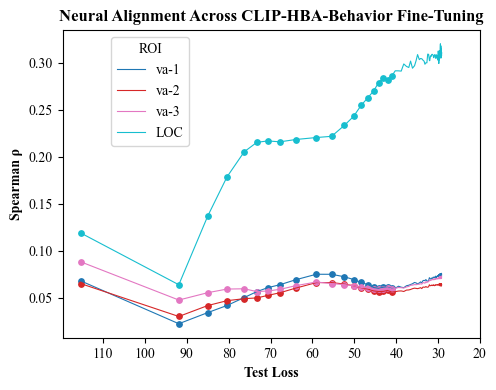

In [149]:
# Plot correlation vs test_loss for each ROI in a different color

import matplotlib.cm as cm

rois = hba_results_df['roi'].unique()
colors = cm.get_cmap('tab10', len(rois))

fig, ax = plt.subplots(figsize=(5, 4))

for i, roi in enumerate(rois):
    roi_df = hba_results_df[hba_results_df['roi'] == roi]
    # Plot line for all epochs
    ax.plot(roi_df['test_loss'], roi_df['rho'], linewidth=.8, color=colors(i), label=roi)
    # Plot only the first 20 epochs as points
    ax.scatter(roi_df['test_loss'].iloc[:20], roi_df['rho'].iloc[:20], s=15, color=colors(i))

# reverse the x-axis
ax.invert_xaxis()
ax.set_title('Neural Alignment Across CLIP-HBA-Behavior Fine-Tuning', fontweight='bold')
ax.set_xlabel('Test Loss', fontweight='bold')
ax.set_ylabel('Spearman ρ', fontweight='bold')

# Place the legend inside the figure, slightly more right, and remove the legend border
ax.legend(title='ROI', loc='upper left', bbox_to_anchor=(0.1, 1.0), frameon=True)
plt.tight_layout()

# Set x-axis ticks to count by 10s
ax = plt.gca()
xmin, xmax = ax.get_xlim()
# Ensure ticks are in decreasing order since x-axis is inverted
if xmin > xmax:
    xticks = np.arange(int(xmin // 10) * 10, int(xmax // 10) * 10 - 1, -10)
else:
    xticks = np.arange(int(xmin // 10) * 10, int(xmax // 10) * 10 + 1, 10)
ax.set_xticks(xticks)

plt.show()

## Curriculum CLIP-HBA-Behavior

## Anti-Curriculum CLIP-HBA-Behavior

# CLIP-HBA-Behavior - Behavioral Alignment

### Load results from CLIP-HBA-Behavior fine-tuning

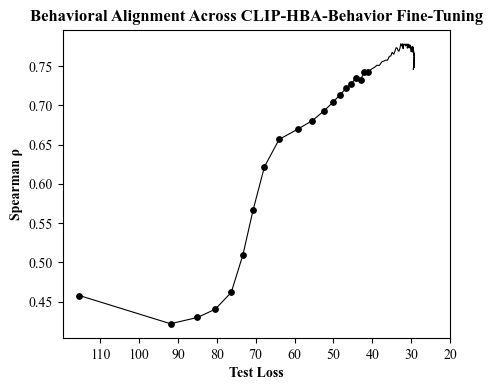

In [ ]:
# Plot behavioral_rsa_rho vs test_loss

plt.plot(cliphba_training_res['test_loss'], cliphba_training_res['behavioral_rsa_rho'], linewidth=.8, color='black')
# plot only the first 20 epochs as points
plt.scatter(cliphba_training_res['test_loss'][:20], cliphba_training_res['behavioral_rsa_rho'][:20], s=15, color='black')
# reverse the x-axis
plt.gca().invert_xaxis()
plt.title('Behavioral Alignment Across CLIP-HBA-Behavior Fine-Tuning', fontweight='bold')
plt.xlabel('Test Loss', fontweight='bold')
plt.ylabel('Spearman ρ', fontweight='bold')
plt.gcf().set_size_inches(5, 4)

# Set x-axis ticks to count by 10s
ax = plt.gca()
xmin, xmax = ax.get_xlim()
# Ensure ticks are in decreasing order since x-axis is inverted
if xmin > xmax:
    xticks = np.arange(int(xmin // 10) * 10, int(xmax // 10) * 10 - 1, -10)
else:
    xticks = np.arange(int(xmin // 10) * 10, int(xmax // 10) * 10 + 1, 10)
ax.set_xticks(xticks)

plt.show()

# CLIP-HBA-Behavior - Neural Alignment

# CLIP-HBA-Behavior with Random Target Shuffling - Neural Alignment

### Loop through the three directories containing the embeddings for the training runs with perturbations at epochs 2, 6, and 12, respectively. Calculate the concept-level embeddings and generate RDMs for all the epochs of each training run. Then, correlate model RDMs with fMRI RDMs. 

In [35]:
# Loop through the three directories to get embeddings from each epoch
# and calculate RDMs and RSA with fMRI ROIs

# Define the three directories to process
directories = [
    '../adaptive-clip/CLIP-HBA/output/cliphba_behavior/20250919_160109_720_concepts',
    '../adaptive-clip/CLIP-HBA/output/cliphba_behavior/20250919_161113_720_concepts', 
    '../adaptive-clip/CLIP-HBA/output/cliphba_behavior/20250919_161747_720_concepts'
]

# Create a dictionary to store results from all directories
all_directory_results = {}

for dir_idx, directory in enumerate(directories):
    print(f"\n{'='*60}")
    print(f"Processing directory {dir_idx + 1}/3: {directory}")
    print(f"{'='*60}")
    
    # Load embeddings from this directory
    hba_embeddings_path = Path(directory)
    
    # List the files in the directory
    hba_embeddings_files = os.listdir(hba_embeddings_path)
    hba_embeddings_files = sorted(
        hba_embeddings_files, 
        key=lambda f: int(f.split('_')[3].replace('epoch', '').replace('.csv', ''))
    )
    
    print(f"Found {len(hba_embeddings_files)} epoch files")
    
    # Create a dictionary to store concept embeddings for each epoch
    hba_concept_embeddings_dict = {}
    
    for file in hba_embeddings_files:
        epoch = file.split('_')[3].replace('epoch', '').replace('.csv', '')
        print(f"Processing epoch {epoch}...")
        
        hba_embeddings = pd.read_csv(os.path.join(hba_embeddings_path, file))
        concept_name = []
        concept_embeddings = []
        
        # Group by the 'concept' column and average the embeddings
        for concept in concept_index:
            hba_embeddings_subset = hba_embeddings[hba_embeddings['concept'] == concept].iloc[:, -66:]
            # Average the embeddings
            hba_concept_embedding = hba_embeddings_subset.mean()
            concept_name.append(concept)
            concept_embeddings.append(hba_concept_embedding)
        
        # Create a DataFrame for this epoch
        hba_concept_embeddings = pd.DataFrame(concept_embeddings)
        hba_concept_embeddings['concept'] = concept_name
        hba_concept_embeddings = hba_concept_embeddings[['concept'] + [col for col in hba_concept_embeddings if col != 'concept']]
        
        # Store in the dictionary
        hba_concept_embeddings_dict[epoch] = hba_concept_embeddings
    
    print(f"Loaded embeddings for {len(hba_concept_embeddings_dict)} epochs")
    
    # Calculate RDMs for each epoch
    hba_concept_rdms_dict = {}
    
    for epoch in hba_concept_embeddings_dict:
        # Take the last 66 columns of the dataframe and convert to numpy array
        hba_concept_embeddings = hba_concept_embeddings_dict[epoch].iloc[:, -66:].to_numpy()
        
        # Create a concept RDM from the concept embeddings
        concept_rdm = 1 - cosine_similarity(hba_concept_embeddings)
        np.fill_diagonal(concept_rdm, 0)
        
        # Extract upper triangular elements
        upper_tri_indices = np.triu_indices_from(concept_rdm, k=1)
        hba_concept_rdms_dict[epoch] = concept_rdm[upper_tri_indices]
    
    print(f"Calculated RDMs for {len(hba_concept_rdms_dict)} epochs")
    
    # Calculate RSA correlations with fMRI ROIs
    roi_alignment_results = {}
    
    for roi in roi_average_upper_triangles:
        print(f"Computing correlations for ROI: {roi}")
        
        # Initialize lists to store results
        epochs = []
        rho_values = []
        
        # Get the reference values (averaged upper triangle for this ROI)
        reference_values = roi_average_upper_triangles[roi]
        
        # Loop through each epoch in the model concept RDMs
        for epoch_str in hba_concept_rdms_dict:
            # Convert epoch to integer
            epoch_int = int(epoch_str)
            
            # Get model values for this epoch
            model_values = hba_concept_rdms_dict[epoch_str]
            
            # Compute Spearman correlation
            rho, p_value = stats.spearmanr(reference_values, model_values)
            
            # Store results
            epochs.append(epoch_int)
            rho_values.append(rho)
        
        # Create DataFrame for this ROI
        roi_alignment_results[roi] = pd.DataFrame({
            'epoch': epochs, 
            'rho': rho_values
        })
        
        print(f"  Computed correlations for {len(epochs)} epochs")
        print(f"  Mean correlation: {np.mean(rho_values):.4f}")
        print(f"  Max correlation: {np.max(rho_values):.4f} at epoch {epochs[np.argmax(rho_values)]}")
    
    # Store results for this directory
    all_directory_results[f"directory_{dir_idx + 1}"] = {
        'path': directory,
        'roi_alignment_results': roi_alignment_results,
        'hba_concept_rdms_dict': hba_concept_rdms_dict,
        'hba_concept_embeddings_dict': hba_concept_embeddings_dict
    }
    
    print(f"Completed processing directory {dir_idx + 1}")

print(f"\n{'='*60}")
print("Summary of all directories:")
print(f"{'='*60}")

for dir_key, dir_data in all_directory_results.items():
    print(f"\n{dir_key}: {dir_data['path']}")
    for roi in dir_data['roi_alignment_results']:
        mean_rho = dir_data['roi_alignment_results'][roi]['rho'].mean()
        max_rho = dir_data['roi_alignment_results'][roi]['rho'].max()
        print(f"  {roi}: mean ρ = {mean_rho:.4f}, max ρ = {max_rho:.4f}")


Processing directory 1/3: ../adaptive-clip/CLIP-HBA/output/cliphba_behavior/20250919_160109_720_concepts
Found 134 epoch files
Processing epoch 1...
Processing epoch 2...
Processing epoch 3...
Processing epoch 4...
Processing epoch 5...
Processing epoch 6...
Processing epoch 7...
Processing epoch 8...
Processing epoch 9...
Processing epoch 10...
Processing epoch 11...
Processing epoch 12...
Processing epoch 13...
Processing epoch 14...
Processing epoch 15...
Processing epoch 16...
Processing epoch 17...
Processing epoch 18...
Processing epoch 19...
Processing epoch 20...
Processing epoch 21...
Processing epoch 22...
Processing epoch 23...
Processing epoch 24...
Processing epoch 25...
Processing epoch 26...
Processing epoch 27...
Processing epoch 28...
Processing epoch 29...
Processing epoch 30...
Processing epoch 31...
Processing epoch 32...
Processing epoch 33...
Processing epoch 34...
Processing epoch 35...
Processing epoch 36...
Processing epoch 37...
Processing epoch 38...
Process

Loaded training results for directory_1: 147 epochs
Loaded training results for directory_2: 131 epochs
Loaded training results for directory_3: 136 epochs


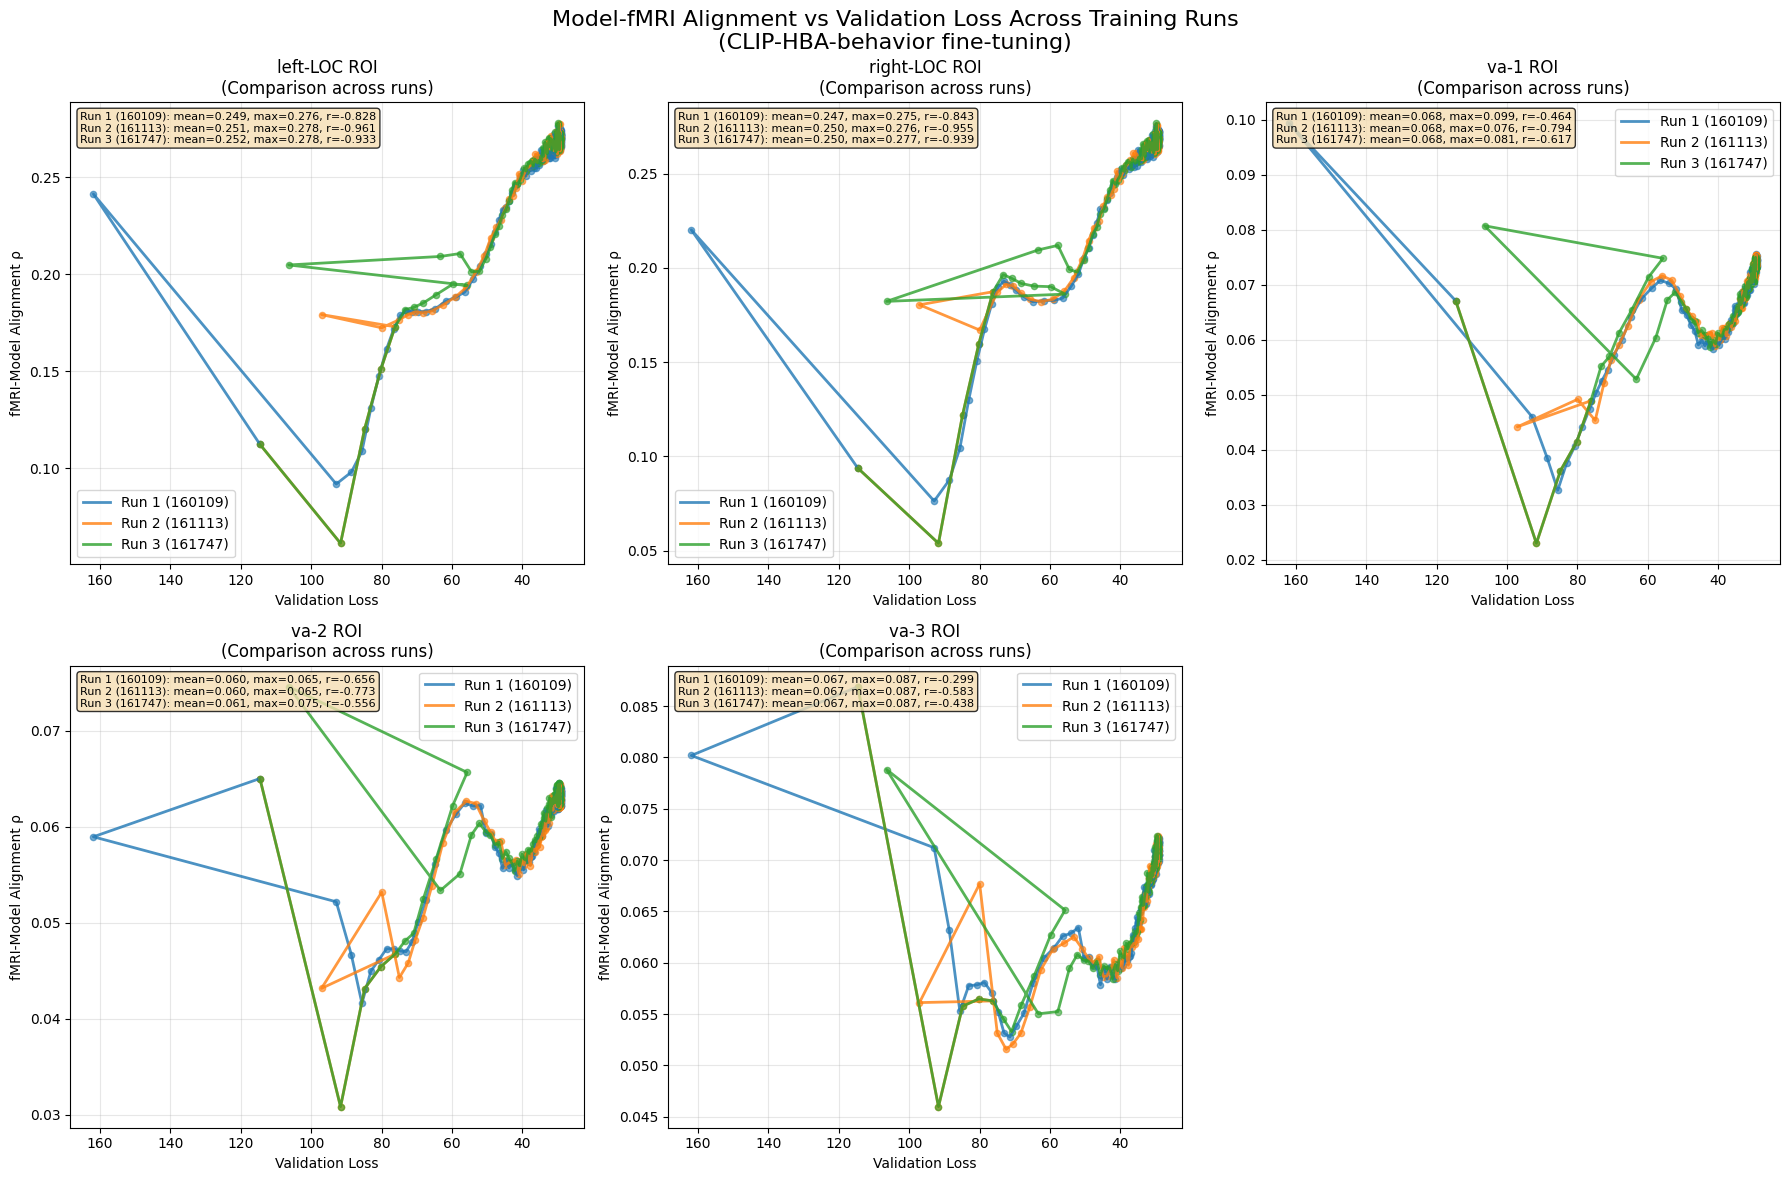


SUMMARY STATISTICS ACROSS ALL RUNS
      ROI            Run  Mean_ρ  Max_ρ  Max_Epoch  Loss_fMRI_r
 left-LOC Run 1 (160109)  0.2485 0.2763         84      -0.8281
 left-LOC Run 2 (161113)  0.2514 0.2777         80      -0.9614
 left-LOC Run 3 (161747)  0.2517 0.2779         84      -0.9326
right-LOC Run 1 (160109)  0.2466 0.2751         84      -0.8425
right-LOC Run 2 (161113)  0.2498 0.2758         84      -0.9546
right-LOC Run 3 (161747)  0.2498 0.2766         84      -0.9395
     va-1 Run 1 (160109)  0.0678 0.0994          2      -0.4638
     va-1 Run 2 (161113)  0.0683 0.0755         91      -0.7943
     va-1 Run 3 (161747)  0.0681 0.0807         12      -0.6166
     va-2 Run 1 (160109)  0.0602 0.0650          1      -0.6564
     va-2 Run 2 (161113)  0.0603 0.0650          1      -0.7731
     va-2 Run 3 (161747)  0.0607 0.0746         12      -0.5560
     va-3 Run 1 (160109)  0.0667 0.0869          1      -0.2989
     va-3 Run 2 (161113)  0.0668 0.0869          1      -0.5827
    

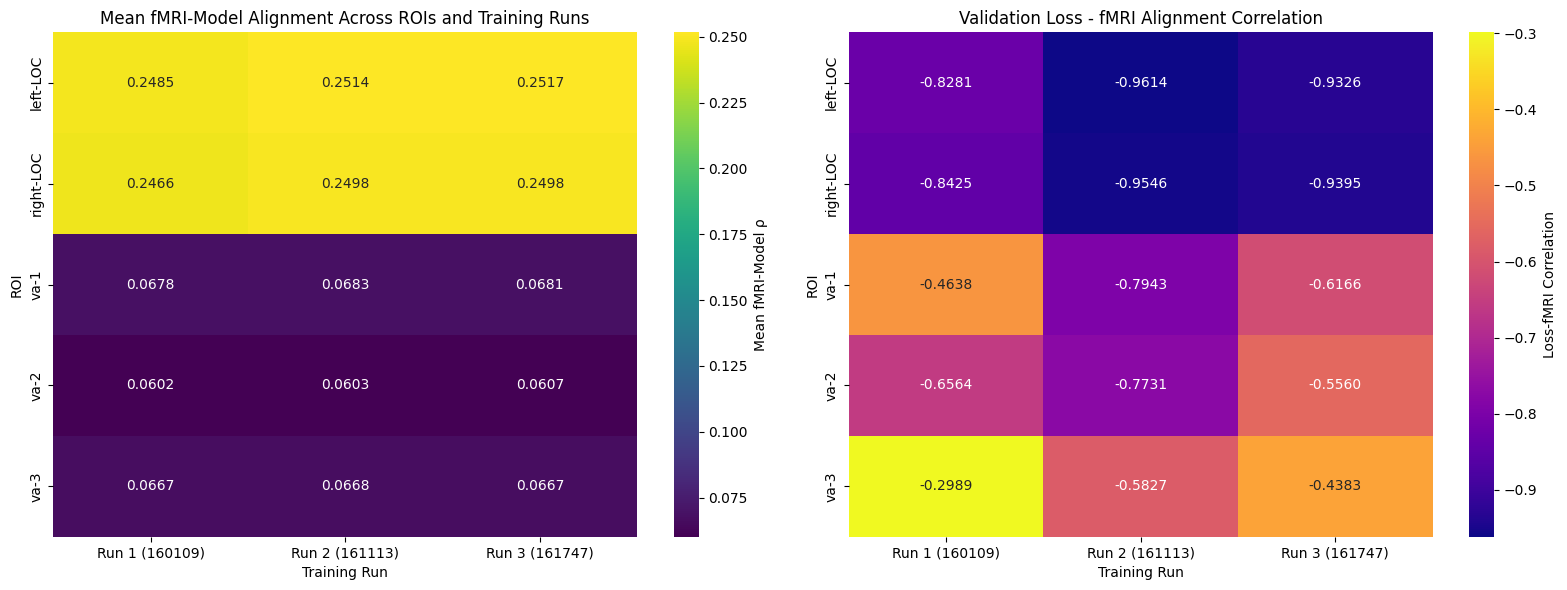


Processing completed for all 3 directories!
Total ROIs analyzed: 5
ROIs: lLOC, rLOC, va-1, va-2, va-3


In [36]:
# Load the training results corresponding to the training run with perturbations at epochs 2, 6, and 12, respectively.
training_results_files = {
    'directory_1': '../adaptive-clip/CLIP-HBA/training_results/training_res_20250919_160109.csv',
    'directory_2': '../adaptive-clip/CLIP-HBA/training_results/training_res_20250919_161113.csv',
    'directory_3': '../adaptive-clip/CLIP-HBA/training_results/training_res_20250919_161747.csv'
}

training_results_data = {}
for dir_key, file_path in training_results_files.items():
    training_results_data[dir_key] = pd.read_csv(file_path)
    print(f"Loaded training results for {dir_key}: {len(training_results_data[dir_key])} epochs")

# Create a comprehensive comparison plot with behavioral_rsa_rho on x-axis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Define colors for each directory
directory_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
directory_names = ['Run 1 (160109)', 'Run 2 (161113)', 'Run 3 (161747)']

# Plot each ROI
rois = sorted(list(roi_average_upper_triangles.keys()))

for i, roi in enumerate(rois):
    ax = axes[i]
    
    for dir_idx, (dir_key, dir_data) in enumerate(all_directory_results.items()):
        roi_data = dir_data['roi_alignment_results'][roi]
        training_data = training_results_data[dir_key]
        
        # Merge the data on epoch to get test_loss (validation loss)
        merged_data = roi_data.merge(training_data[['epoch', 'test_loss']], on='epoch', how='inner')
        
        # Rename ROI labels for better readability
        roi_display_name = roi.replace('lLOC', 'left-LOC').replace('rLOC', 'right-LOC')
        
        # Plot the correlation values with test_loss on x-axis
        ax.plot(merged_data['test_loss'], merged_data['rho'], 
               label=directory_names[dir_idx], 
               color=directory_colors[dir_idx], 
               linewidth=2, alpha=0.8)
        
        # Add scatter points
        ax.scatter(merged_data['test_loss'], merged_data['rho'], 
                  color=directory_colors[dir_idx], 
                  alpha=0.6, s=20)
    
    # Customize the plot
    ax.set_xlabel('Validation Loss')
    ax.set_ylabel('fMRI-Model Alignment ρ')
    ax.set_title(f'{roi_display_name} ROI\n(Comparison across runs)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Invert x-axis so loss goes from high to low (better performance on right)
    ax.invert_xaxis()
    
    # Add correlation statistics as text
    stats_text = ""
    for dir_idx, (dir_key, dir_data) in enumerate(all_directory_results.items()):
        roi_data = dir_data['roi_alignment_results'][roi]
        training_data = training_results_data[dir_key]
        merged_data = roi_data.merge(training_data[['epoch', 'test_loss']], on='epoch', how='inner')
        
        mean_rho = merged_data['rho'].mean()
        max_rho = merged_data['rho'].max()
        # Calculate correlation between validation loss and fMRI alignment
        loss_fmri_corr = merged_data['test_loss'].corr(merged_data['rho'])
        stats_text += f"{directory_names[dir_idx]}: mean={mean_rho:.3f}, max={max_rho:.3f}, r={loss_fmri_corr:.3f}\n"
    
    ax.text(0.02, 0.98, stats_text.strip(), transform=ax.transAxes, 
            verticalalignment='top', fontsize=8,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Remove empty subplot if needed
if len(rois) < len(axes):
    fig.delaxes(axes[-1])

plt.suptitle('Model-fMRI Alignment vs Validation Loss Across Training Runs\n(CLIP-HBA-behavior fine-tuning)', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Create a summary statistics table
print("\n" + "="*80)
print("SUMMARY STATISTICS ACROSS ALL RUNS")
print("="*80)

summary_data = []

for roi in rois:
    roi_display_name = roi.replace('lLOC', 'left-LOC').replace('rLOC', 'right-LOC')
    
    for dir_idx, (dir_key, dir_data) in enumerate(all_directory_results.items()):
        roi_data = dir_data['roi_alignment_results'][roi]
        training_data = training_results_data[dir_key]
        merged_data = roi_data.merge(training_data[['epoch', 'test_loss']], on='epoch', how='inner')
        
        mean_rho = merged_data['rho'].mean()
        max_rho = merged_data['rho'].max()
        max_epoch = merged_data.loc[merged_data['rho'].idxmax(), 'epoch']
        loss_fmri_corr = merged_data['test_loss'].corr(merged_data['rho'])
        
        summary_data.append({
            'ROI': roi_display_name,
            'Run': directory_names[dir_idx],
            'Mean_ρ': mean_rho,
            'Max_ρ': max_rho,
            'Max_Epoch': max_epoch,
            'Loss_fMRI_r': loss_fmri_corr
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False, float_format='%.4f'))

# Create heatmaps showing different correlation metrics across runs and ROIs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap 1: Mean fMRI-Model alignment
pivot_table_mean = summary_df.pivot(index='ROI', columns='Run', values='Mean_ρ')
sns.heatmap(pivot_table_mean, annot=True, fmt='.4f', cmap='viridis', 
            cbar_kws={'label': 'Mean fMRI-Model ρ'}, ax=ax1)
ax1.set_title('Mean fMRI-Model Alignment Across ROIs and Training Runs')
ax1.set_xlabel('Training Run')
ax1.set_ylabel('ROI')

# Heatmap 2: Validation Loss-fMRI correlation
pivot_table_loss = summary_df.pivot(index='ROI', columns='Run', values='Loss_fMRI_r')
sns.heatmap(pivot_table_loss, annot=True, fmt='.4f', cmap='plasma', 
            cbar_kws={'label': 'Loss-fMRI Correlation'}, ax=ax2)
ax2.set_title('Validation Loss - fMRI Alignment Correlation')
ax2.set_xlabel('Training Run')
ax2.set_ylabel('ROI')

plt.tight_layout()
plt.show()

print(f"\nProcessing completed for all {len(directories)} directories!")
print(f"Total ROIs analyzed: {len(rois)}")
print(f"ROIs: {', '.join(rois)}")


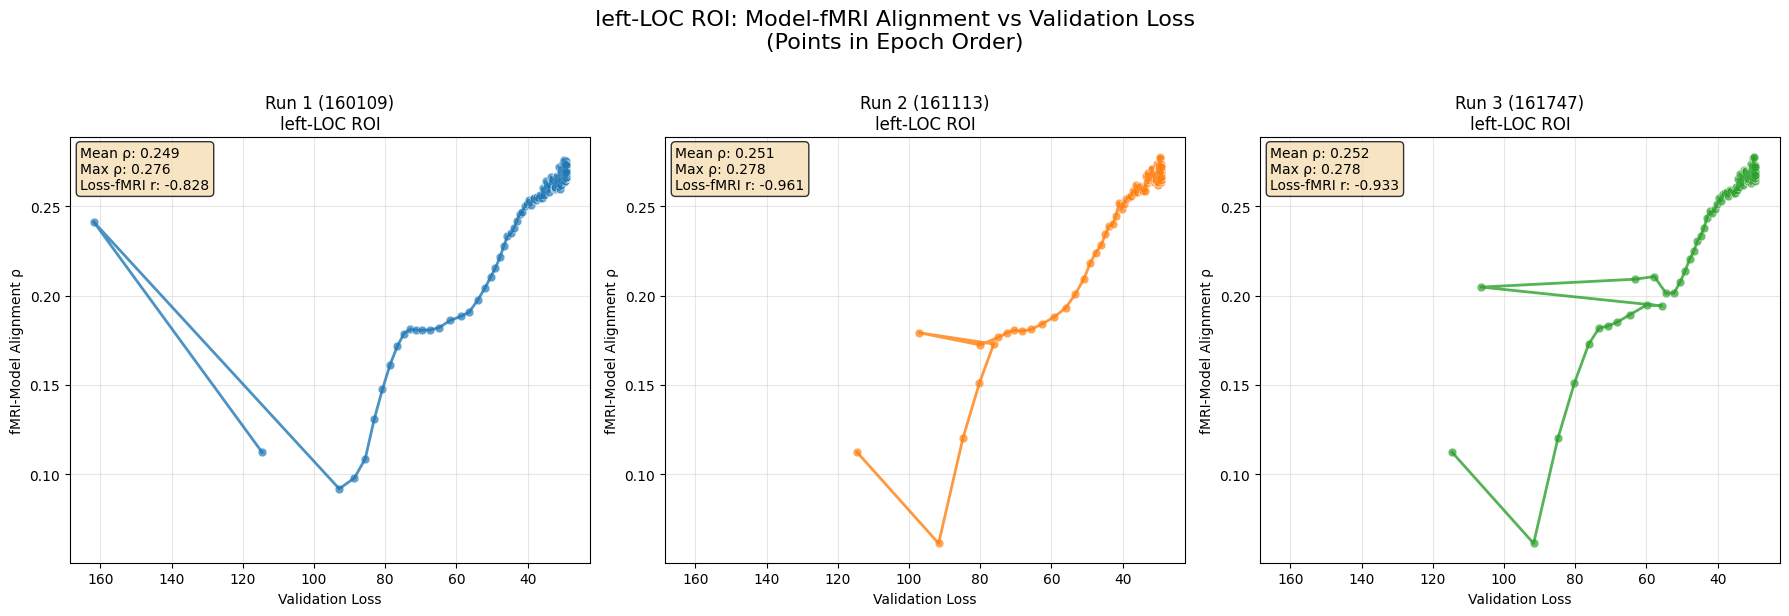

CORRECTED: Points are now connected in chronological epoch order!


In [37]:
# CORRECTED: Create focused plot for left LOC ROI with points in epoch order
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors and names for each directory
directory_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
directory_names = ['Run 1 (160109)', 'Run 2 (161113)', 'Run 3 (161747)']

# Focus on left LOC ROI
roi = 'lLOC'
roi_display_name = 'left-LOC'

# Get the range of values to set consistent scales
all_x_values = []
all_y_values = []

for dir_idx, (dir_key, dir_data) in enumerate(all_directory_results.items()):
    roi_data = dir_data['roi_alignment_results'][roi]
    training_data = training_results_data[dir_key]
    merged_data = roi_data.merge(training_data[['epoch', 'test_loss']], on='epoch', how='inner')
    all_x_values.extend(merged_data['test_loss'].values)
    all_y_values.extend(merged_data['rho'].values)

# Set consistent axis limits with some padding
x_min, x_max = min(all_x_values), max(all_x_values)
y_min, y_max = min(all_y_values), max(all_y_values)
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05

# Plot each run in its own subplot
for dir_idx, (dir_key, dir_data) in enumerate(all_directory_results.items()):
    ax = axes[dir_idx]
    
    roi_data = dir_data['roi_alignment_results'][roi]
    training_data = training_results_data[dir_key]
    merged_data = roi_data.merge(training_data[['epoch', 'test_loss']], on='epoch', how='inner')
    
    # Sort by epoch to maintain chronological order (CORRECTED)
    merged_data_sorted = merged_data.sort_values('epoch')
    
    # Plot the correlation values in epoch order
    ax.plot(merged_data_sorted['test_loss'], merged_data_sorted['rho'], 
           color=directory_colors[dir_idx], 
           linewidth=2, alpha=0.8)
    
    # Add scatter points in epoch order
    ax.scatter(merged_data_sorted['test_loss'], merged_data_sorted['rho'], 
              color=directory_colors[dir_idx], 
              alpha=0.7, s=40, edgecolors='white', linewidth=0.5)
    
    # Customize the plot
    ax.set_xlabel('Validation Loss')
    ax.set_ylabel('fMRI-Model Alignment ρ')
    ax.set_title(f'{directory_names[dir_idx]}\n{roi_display_name} ROI')
    ax.grid(True, alpha=0.3)
    
    # Set consistent scales across all subplots
    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)
    
    # Invert x-axis so loss goes from high to low
    ax.invert_xaxis()
    
    # Add statistics text
    mean_rho = merged_data['rho'].mean()
    max_rho = merged_data['rho'].max()
    loss_fmri_corr = merged_data['test_loss'].corr(merged_data['rho'])
    
    stats_text = f"Mean ρ: {mean_rho:.3f}\nMax ρ: {max_rho:.3f}\nLoss-fMRI r: {loss_fmri_corr:.3f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle(f'{roi_display_name} ROI: Model-fMRI Alignment vs Validation Loss\n(Points in Epoch Order)', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("CORRECTED: Points are now connected in chronological epoch order!")

Loaded training results for directory_1: 147 epochs
Loaded training results for directory_2: 131 epochs
Loaded training results for directory_3: 136 epochs


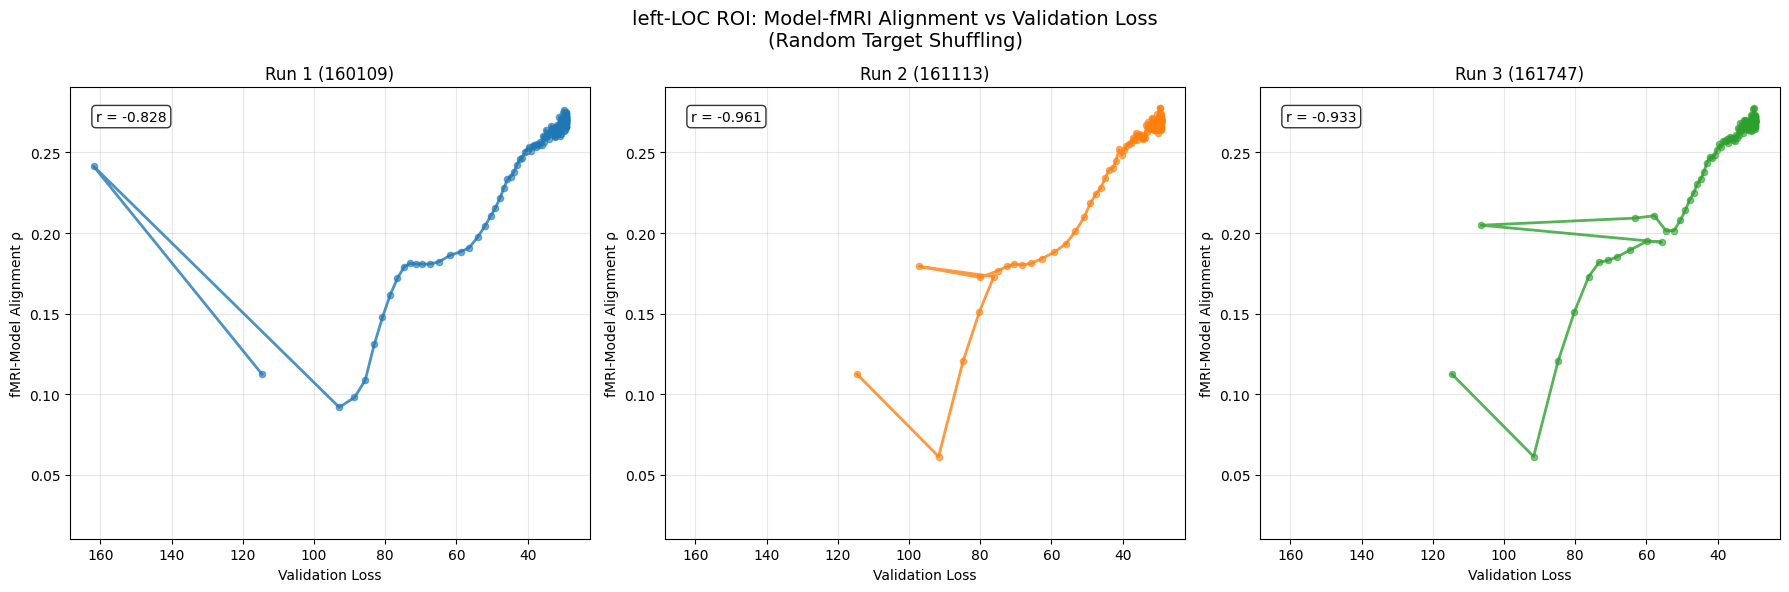

Created separate figure for left-LOC ROI


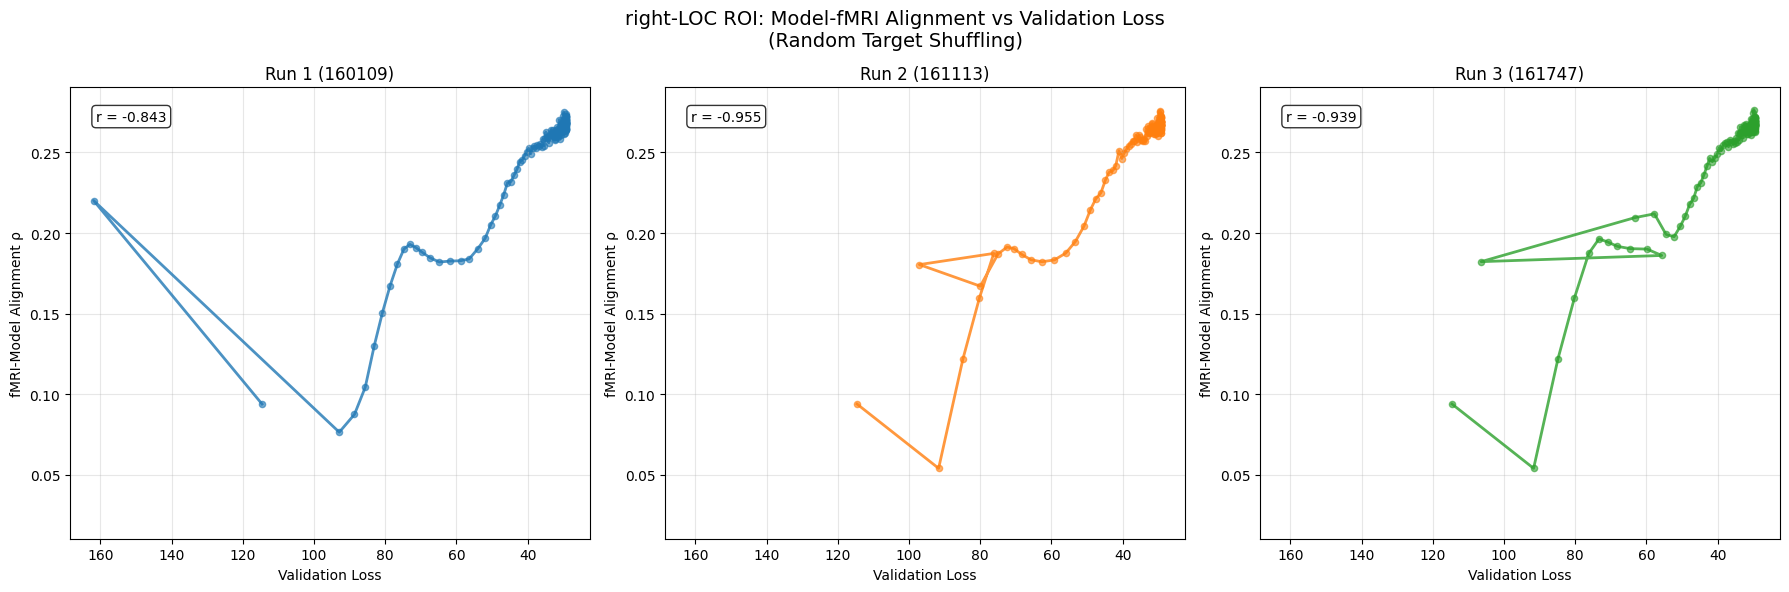

Created separate figure for right-LOC ROI


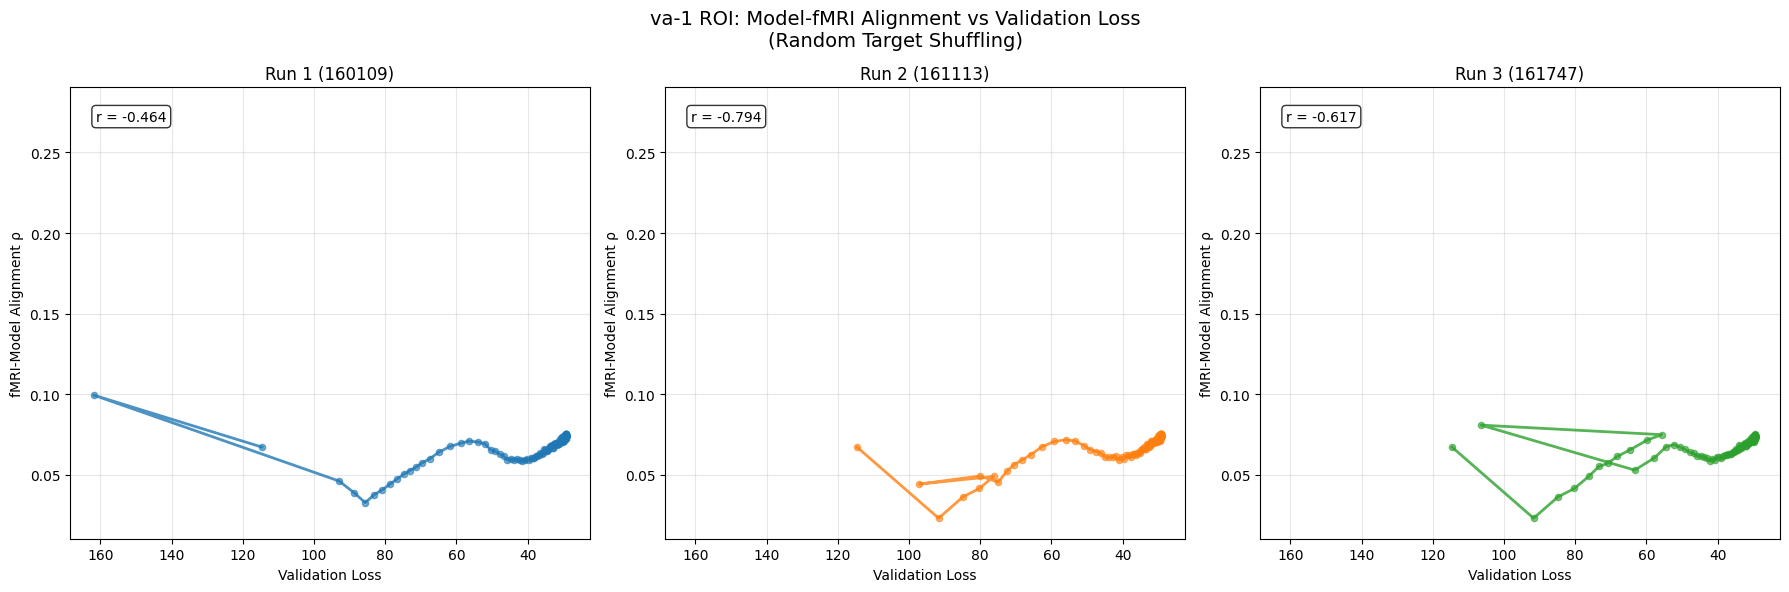

Created separate figure for va-1 ROI


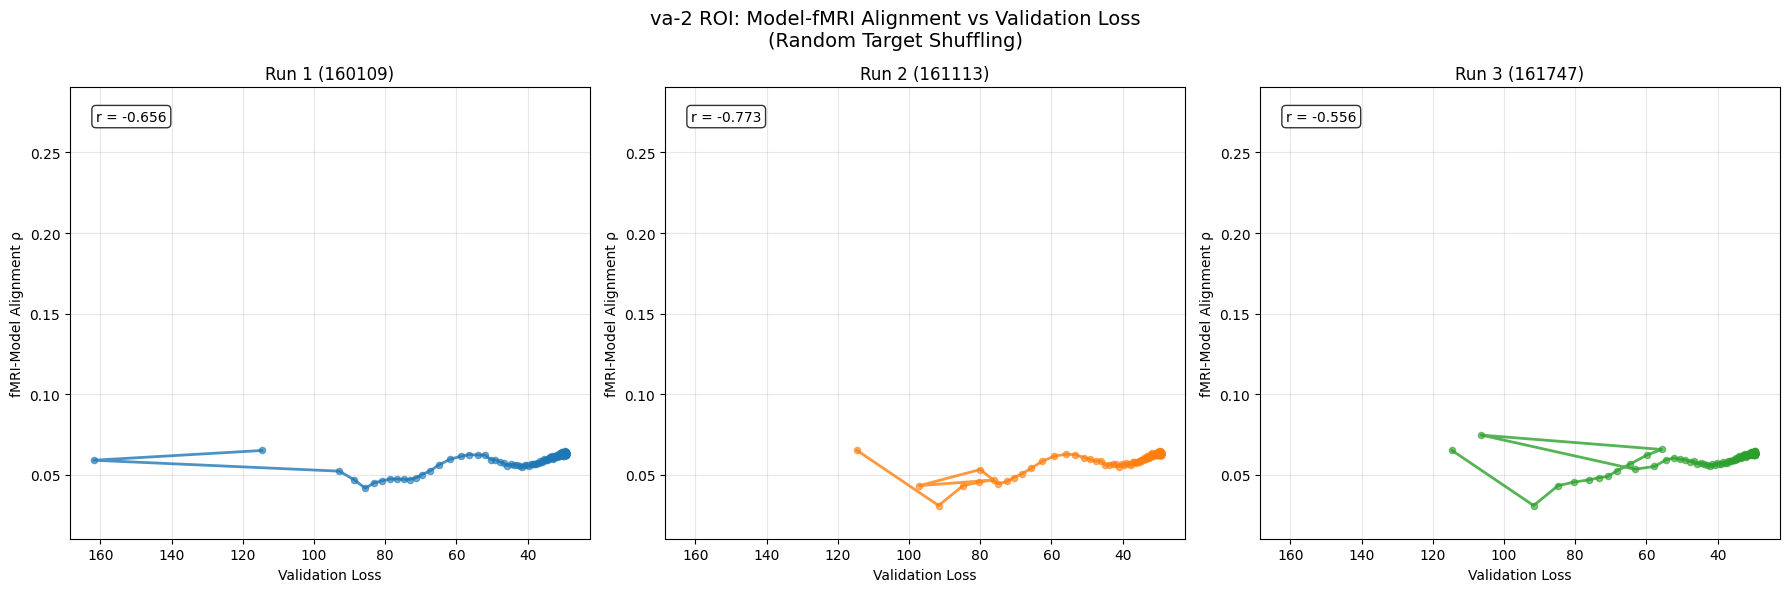

Created separate figure for va-2 ROI


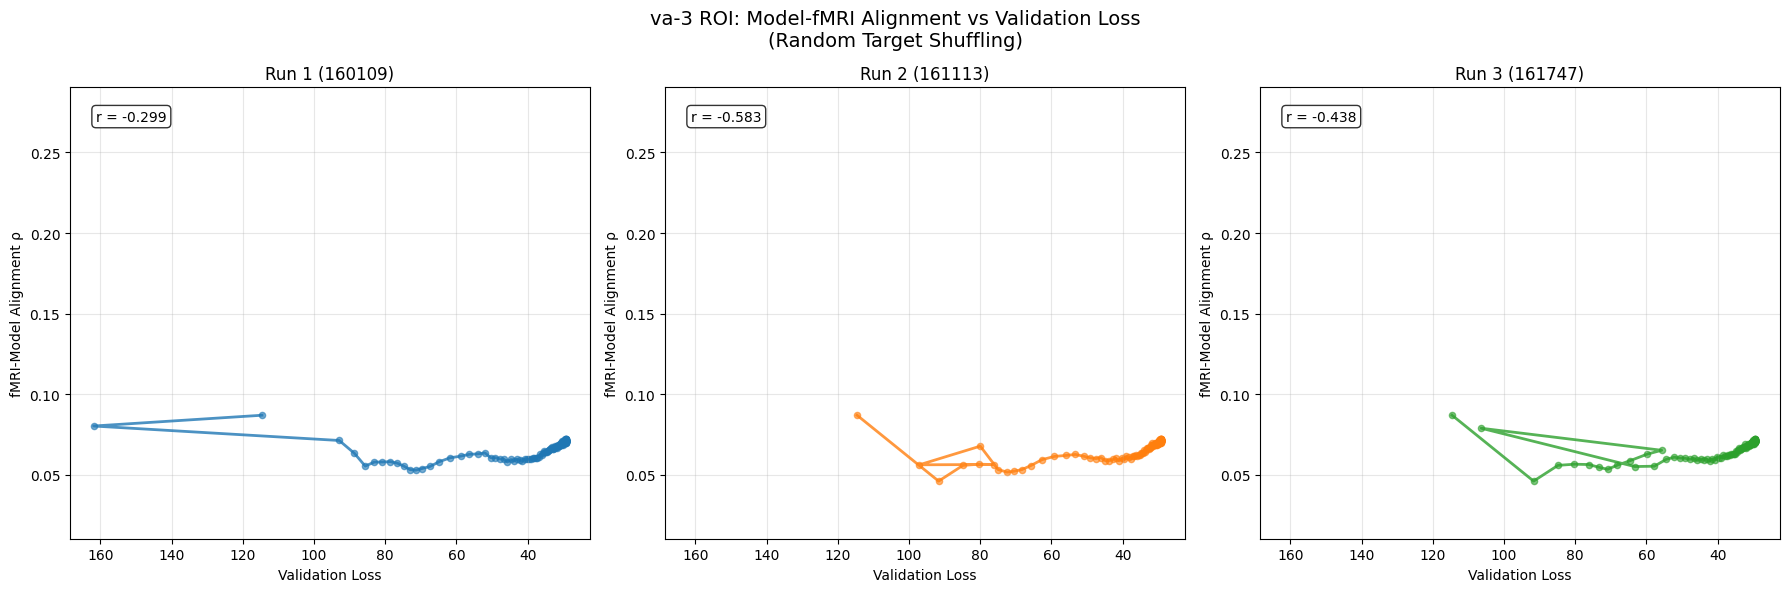

Created separate figure for va-3 ROI
All ROI figures created successfully!


In [38]:
# Create separate figures for each ROI - each with 3 subplots (one per run)
# All subplots will share the same x and y axis scale for comparability

# Get the list of ROIs
rois = sorted(list(roi_average_upper_triangles.keys()))

# Define colors for each run
run_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
run_names = ['Run 1 (160109)', 'Run 2 (161113)', 'Run 3 (161747)']

# Get training results for each directory
training_results_files = {}
for dir_idx, dir_key in enumerate(sorted(all_directory_results.keys())):
    # Extract directory name from path for training results
    dir_path = all_directory_results[dir_key]['path']
    if '160109' in dir_path:
        training_results_files[dir_key] = '../adaptive-clip/CLIP-HBA/training_results/training_res_20250919_160109.csv'
    elif '161113' in dir_path:
        training_results_files[dir_key] = '../adaptive-clip/CLIP-HBA/training_results/training_res_20250919_161113.csv'
    elif '161747' in dir_path:
        training_results_files[dir_key] = '../adaptive-clip/CLIP-HBA/training_results/training_res_20250919_161747.csv'

# Load training results for each directory
training_results_data = {}
for dir_key, file_path in training_results_files.items():
    training_results_data[dir_key] = pd.read_csv(file_path)
    print(f"Loaded training results for {dir_key}: {len(training_results_data[dir_key])} epochs")

# --- Compute global x/y axis limits for all ROIs and runs ---
all_test_losses = []
all_rhos = []

for roi in rois:
    for dir_key, dir_data in sorted(all_directory_results.items()):
        roi_data = dir_data['roi_alignment_results'][roi]
        training_data = training_results_data[dir_key]
        merged_data = roi_data.merge(training_data[['epoch', 'test_loss']], on='epoch', how='inner')
        all_test_losses.extend(merged_data['test_loss'].values)
        all_rhos.extend(merged_data['rho'].values)

x_min, x_max = min(all_test_losses), max(all_test_losses)
y_min, y_max = min(all_rhos), max(all_rhos)

# Add a small padding for aesthetics
x_padding = 0.05 * (x_max - x_min) if x_max > x_min else 1.0
y_padding = 0.05 * (y_max - y_min) if y_max > y_min else 0.05

# Create a separate figure for each ROI
for roi_idx, roi in enumerate(rois):
    roi_display_name = roi.replace('lLOC', 'left-LOC').replace('rLOC', 'right-LOC')
    
    # Create a new figure for this ROI with 3 subplots (one per run)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    # Plot each run in its own subplot
    for run_idx, (dir_key, dir_data) in enumerate(sorted(all_directory_results.items())):
        ax = axes[run_idx]
        
        # Get data for this ROI and run
        roi_data = dir_data['roi_alignment_results'][roi]
        training_data = training_results_data[dir_key]
        
        # Merge the data on epoch to get test_loss
        merged_data = roi_data.merge(training_data[['epoch', 'test_loss']], on='epoch', how='inner')
        
        # Plot the correlation values
        ax.plot(merged_data['test_loss'], merged_data['rho'], 
               color=run_colors[run_idx], 
               linewidth=2, alpha=0.8)
        
        # Add scatter points
        ax.scatter(merged_data['test_loss'], merged_data['rho'], 
                  color=run_colors[run_idx], 
                  alpha=0.6, s=20)
        
        # Customize the plot
        ax.set_xlabel('Validation Loss')
        ax.set_ylabel('fMRI-Model Alignment ρ')
        ax.set_title(f'{run_names[run_idx]}')
        ax.grid(True, alpha=0.3)
        
        # Set consistent x/y axis limits
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        ax.set_ylim(y_min - y_padding, y_max + y_padding)
        
        # Invert x-axis so loss goes from high to low
        ax.invert_xaxis()
        
        # Add correlation statistics as text
        corr_coef = merged_data['test_loss'].corr(merged_data['rho'])
        ax.text(0.05, 0.95, f'r = {corr_coef:.3f}', 
               transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add overall title for this ROI
    plt.suptitle(f'{roi_display_name} ROI: Model-fMRI Alignment vs Validation Loss\n(Random Target Shuffling)', 
                 fontsize=14, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    print(f"Created separate figure for {roi_display_name} ROI")

print("All ROI figures created successfully!")

In [68]:
# Save all of the points from the previous plot to a CSV file, including run number and model name

# Collect all points from all ROIs and runs
all_points = []

for roi_idx, roi in enumerate(sorted(list(roi_average_upper_triangles.keys()))):
    for run_idx, dir_key in enumerate(sorted(all_directory_results.keys())):
        training_data = training_results_data[dir_key]
        roi_data = roi_alignment_results[roi]
        merged_data = roi_data.merge(training_data[['epoch', 'test_loss']], on='epoch', how='inner')
        for i, row in merged_data.iterrows():
            all_points.append({
                'roi': roi,
                'run': run_names[run_idx],
                'run_number': run_idx + 1,  # 1-based run number
                'epoch': row['epoch'],
                'test_loss': row['test_loss'],
                'rho': row['rho'],
                'model_name': "CLIP-HBA-behavior with random target generation"
            })

# Convert to DataFrame and save
all_points_df = pd.DataFrame(all_points)
all_points_df.to_csv('random_target_neural_alignment_vs_loss.csv', index=False)
print(f"Saved {len(all_points_df)} points to random_target_neural_alignment_vs_loss.csv")

Saved 1620 points to random_target_neural_alignment_vs_loss.csv


Loaded training results for directory_1: 118 epochs
Loaded training results for directory_2: 111 epochs
Loaded training results for directory_3: 107 epochs


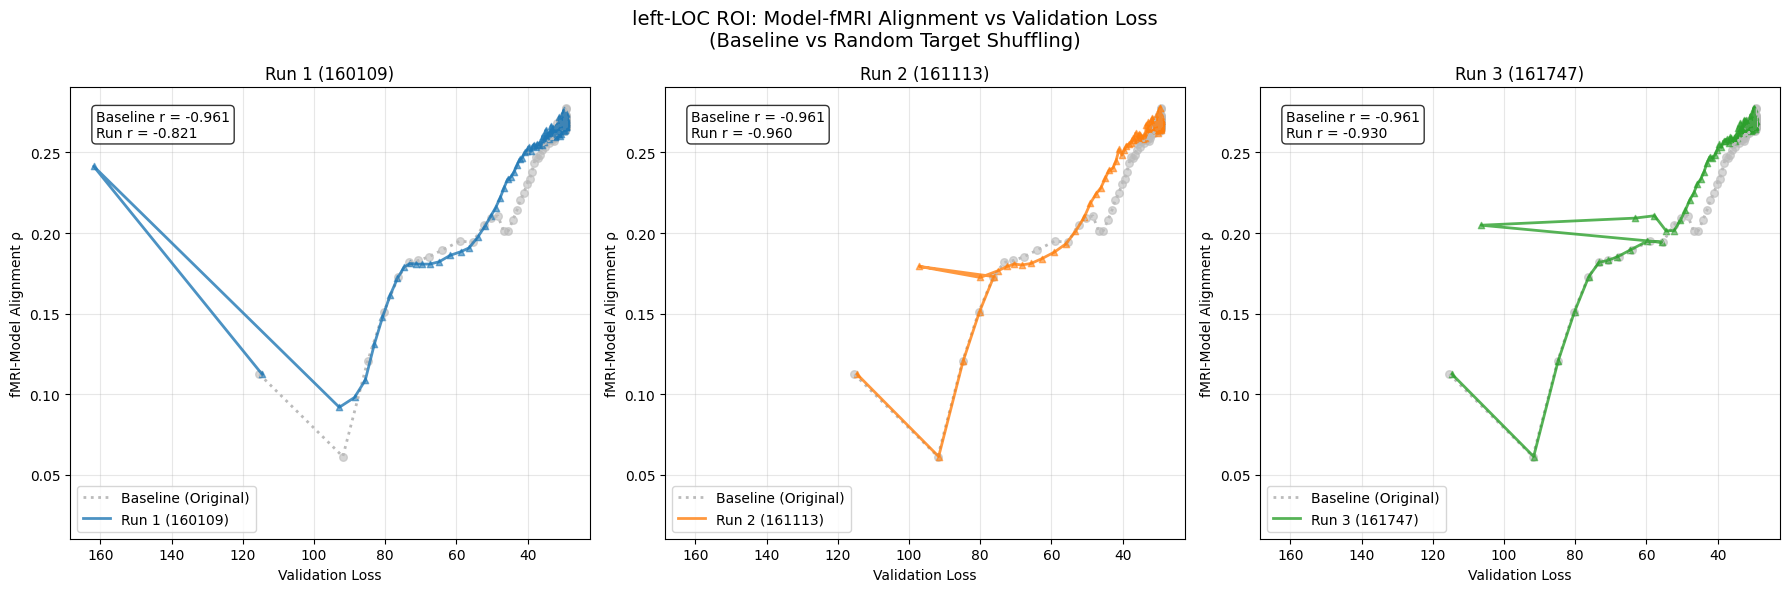

Created separate figure for left-LOC ROI with baseline comparison


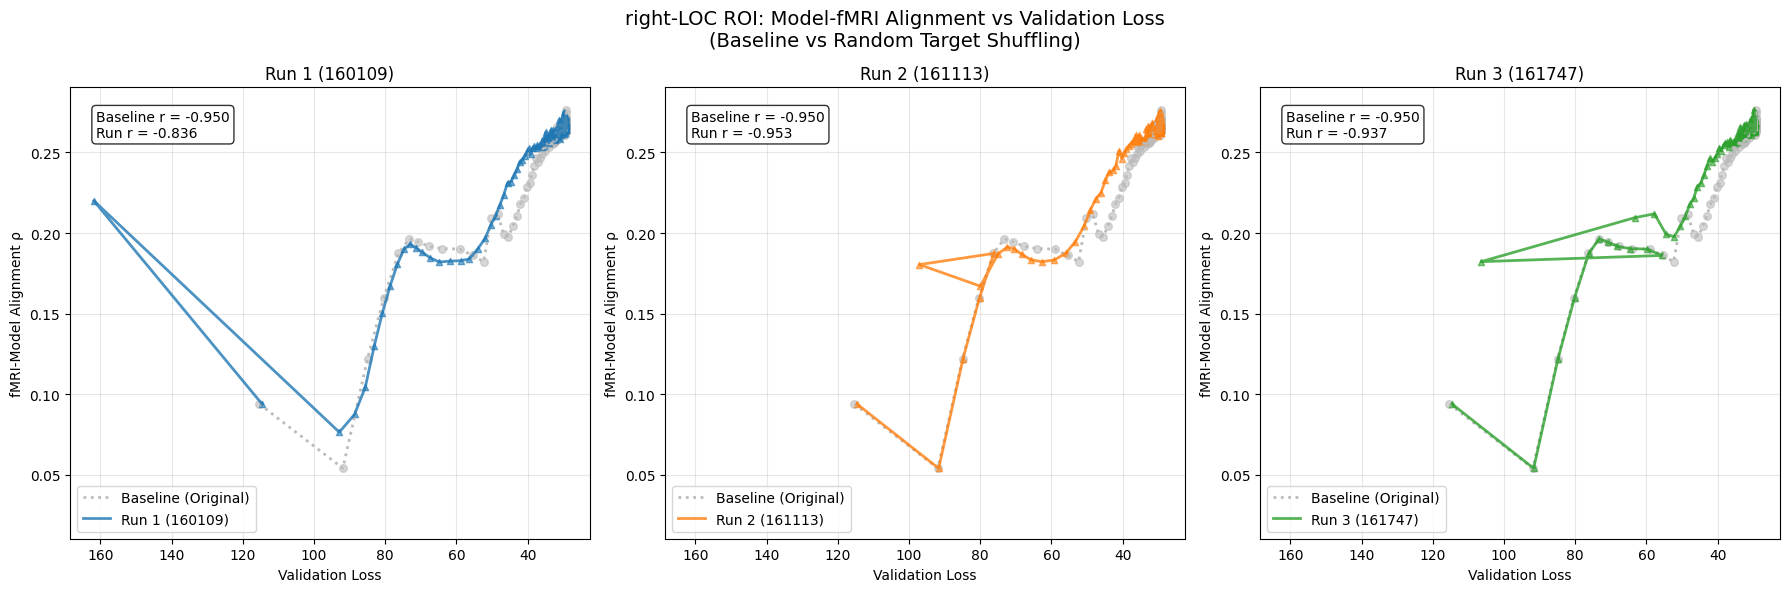

Created separate figure for right-LOC ROI with baseline comparison


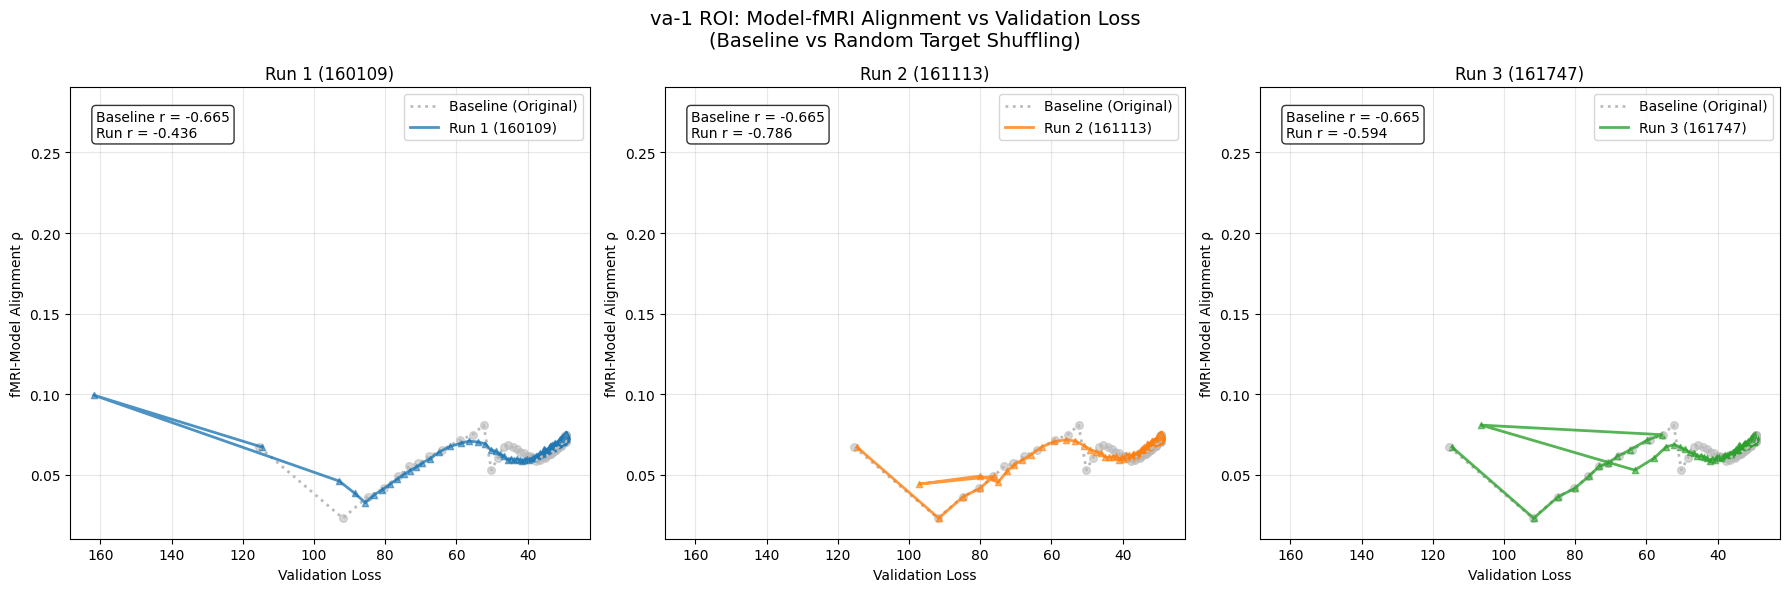

Created separate figure for va-1 ROI with baseline comparison


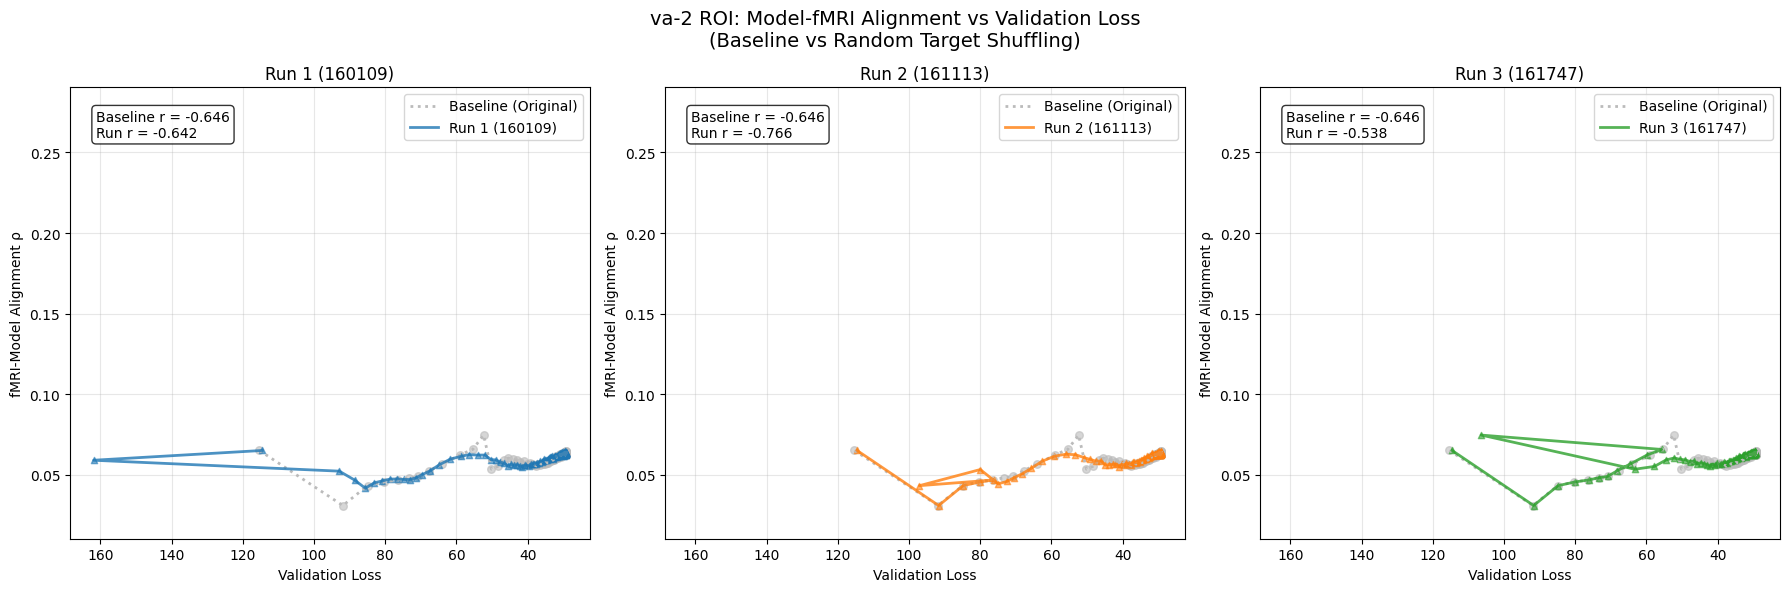

Created separate figure for va-2 ROI with baseline comparison


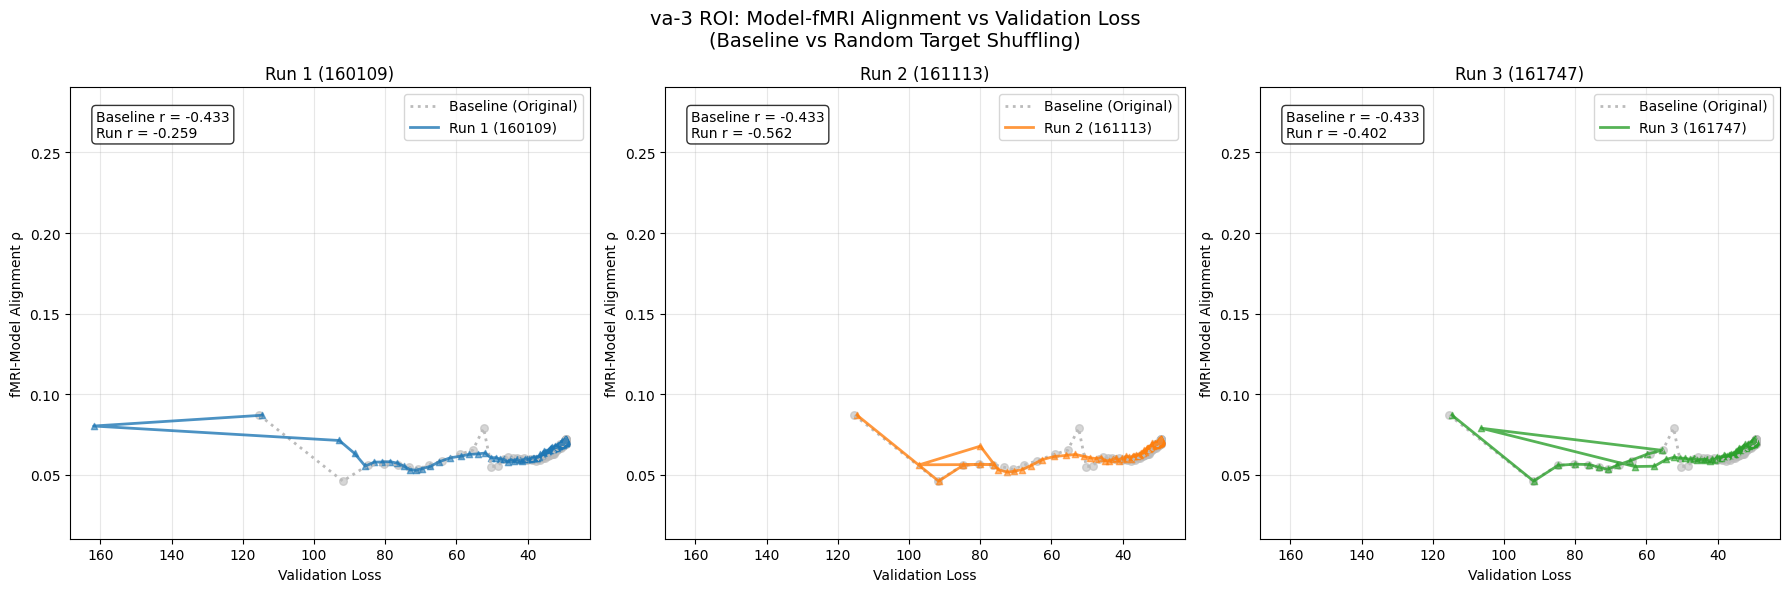

Created separate figure for va-3 ROI with baseline comparison
All ROI figures with baseline comparison created successfully!


In [31]:
# Create separate figures for each ROI - each with 3 subplots (one per run)
# WITH BASELINE CURVE OVERLAID for comparison
# All plots (no matter the ROI) have the same x and y axis

# Get the list of ROIs
rois = sorted(list(roi_average_upper_triangles.keys()))

# Define colors for each run
run_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
run_names = ['Run 1 (160109)', 'Run 2 (161113)', 'Run 3 (161747)']

# Load baseline training results (original CLIP-HBA-behavior)
baseline_training_results = pd.read_csv('../adaptive-clip/CLIP-HBA/training_results/training_res_20250916_172925.csv')

# Get training results for each directory
training_results_files = {}
for dir_idx, dir_key in enumerate(sorted(all_directory_results.keys())):
    # Extract directory name from path for training results
    dir_path = all_directory_results[dir_key]['path']
    if '160109' in dir_path:
        training_results_files[dir_key] = '../adaptive-clip/CLIP-HBA/training_results/training_res_20250919_160109.csv'
    elif '161113' in dir_path:
        training_results_files[dir_key] = '../adaptive-clip/CLIP-HBA/training_results/training_res_20250919_161113.csv'
    elif '161747' in dir_path:
        training_results_files[dir_key] = '../adaptive-clip/CLIP-HBA/training_results/training_res_20250919_161747.csv'

# Load training results for each directory
training_results_data = {}
for dir_key, file_path in training_results_files.items():
    training_results_data[dir_key] = pd.read_csv(file_path)
    print(f"Loaded training results for {dir_key}: {len(training_results_data[dir_key])} epochs")

# --- Compute global x/y axis limits across all ROIs and runs ---

all_test_losses = []
all_rhos = []

# Baseline
for roi in rois:
    baseline_data = roi_alignment_results[roi]
    baseline_merged = baseline_data.merge(baseline_training_results[['epoch', 'test_loss']], on='epoch', how='inner')
    all_test_losses.extend(baseline_merged['test_loss'].values)
    all_rhos.extend(baseline_merged['rho'].values)

# All runs
for roi in rois:
    for dir_key, dir_data in sorted(all_directory_results.items()):
        roi_data = dir_data['roi_alignment_results'][roi]
        training_data = training_results_data[dir_key]
        merged_data = roi_data.merge(training_data[['epoch', 'test_loss']], on='epoch', how='inner')
        all_test_losses.extend(merged_data['test_loss'].values)
        all_rhos.extend(merged_data['rho'].values)

# Compute min/max and padding
x_min, x_max = min(all_test_losses), max(all_test_losses)
y_min, y_max = min(all_rhos), max(all_rhos)
x_padding = 0.05 * (x_max - x_min) if x_max > x_min else 1.0
y_padding = 0.05 * (y_max - y_min) if y_max > y_min else 0.05

# --- Plotting ---

# Create a separate figure for each ROI
for roi_idx, roi in enumerate(rois):
    roi_display_name = roi.replace('lLOC', 'left-LOC').replace('rLOC', 'right-LOC')
    
    # Create a new figure for this ROI with 3 subplots (one per run)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Get baseline data for this ROI
    baseline_data = roi_alignment_results[roi]
    baseline_merged = baseline_data.merge(baseline_training_results[['epoch', 'test_loss']], on='epoch', how='inner')
    
    # Plot each run in its own subplot
    for run_idx, (dir_key, dir_data) in enumerate(sorted(all_directory_results.items())):
        ax = axes[run_idx]
        
        # Get data for this ROI and run
        roi_data = dir_data['roi_alignment_results'][roi]
        training_data = training_results_data[dir_key]
        
        # Merge the data on epoch to get test_loss
        merged_data = roi_data.merge(training_data[['epoch', 'test_loss']], on='epoch', how='inner')
        
        # Plot the baseline curve first (so it appears in background)
        ax.plot(
            baseline_merged['test_loss'], baseline_merged['rho'],
            color='#bbbbbb', linewidth=2, alpha=1.0, linestyle=':',
            label='Baseline (Original)'
        )
        
        # Plot the random shuffle run
        ax.plot(merged_data['test_loss'], merged_data['rho'], 
               color=run_colors[run_idx], 
               linewidth=2, alpha=0.8, linestyle='-',
               label=f'{run_names[run_idx]}')
        
        # Add scatter points for both baseline and run
        ax.scatter(baseline_merged['test_loss'], baseline_merged['rho'], 
                  color='#bbbbbb', alpha=0.6, s=30, marker='o')
        ax.scatter(merged_data['test_loss'], merged_data['rho'], 
                  color=run_colors[run_idx], 
                  alpha=0.6, s=20, marker='^')
        
        # Customize the plot
        ax.set_xlabel('Validation Loss')
        ax.set_ylabel('fMRI-Model Alignment ρ')
        ax.set_title(f'{run_names[run_idx]}')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Set consistent x/y axis limits for all plots
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        ax.set_ylim(y_min - y_padding, y_max + y_padding)
        
        # Invert x-axis so loss goes from high to low
        ax.invert_xaxis()
        
        # Add correlation statistics as text
        baseline_corr = baseline_merged['test_loss'].corr(baseline_merged['rho'])
        run_corr = merged_data['test_loss'].corr(merged_data['rho'])
        
        ax.text(0.05, 0.95, f'Baseline r = {baseline_corr:.3f}\nRun r = {run_corr:.3f}', 
               transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add overall title for this ROI
    plt.suptitle(f'{roi_display_name} ROI: Model-fMRI Alignment vs Validation Loss\n(Baseline vs Random Target Shuffling)', 
                 fontsize=14, y=0.98)
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    print(f"Created separate figure for {roi_display_name} ROI with baseline comparison")

print("All ROI figures with baseline comparison created successfully!")



In [ ]:
# Plot the difference between the baseline and the random target shuffling runs for every ROI

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume baseline_results and run_results are already loaded DataFrames with columns: ['roi', 'test_loss', 'rho']
# If not, load them here (adjust paths as needed)
# baseline_results = pd.read_csv('frrsa/cliphba_behavior_neural_alignment_vs_loss.csv')
# run_results = pd.read_csv('frrsa/cliphba_behavior_neural_alignment_vs_loss_random.csv')

# If you have a list of run_results for multiple shuffles, average them first
# For this example, assume run_results is already averaged or is a single run

# Get unique ROIs
rois = sorted(baseline_training_results['roi'].unique())

# Prepare to store differences for each ROI
diffs = []

for roi in rois:
    # Get baseline and run data for this ROI
    base = baseline_training_results[baseline_training_results['roi'] == roi].sort_values('epoch')
    run = run_results[run_results['roi'] == roi].sort_values('epoch')
    
    # Align on epoch (in case some epochs are missing)
    merged = pd.merge(base, run, on='epoch', suffixes=('_baseline', '_run'))
    
    # Compute difference in rho (alignment) at each epoch
    merged['rho_diff'] = merged['spearman_rho_baseline'] - merged['spearman_rho_run']
    diffs.append((roi, merged['epoch'], merged['rho_diff']))

# Plot
plt.figure(figsize=(12, 6))
for roi, epochs, rho_diff in diffs:
    plt.plot(epochs, rho_diff, marker='o', label=roi)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Baseline ρ - Shuffled ρ')
plt.title('Difference in Model-fMRI Alignment (ρ) Between Baseline and Random Target Shuffling')
plt.legend(title='ROI')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'baseline_results' is not defined

# AlexNet on CIFAR-100 - Behavioral Alignment

# AlexNet on CIFAR-100 - Neural Alignment

# ResNet on CIFAR-100 - Behavioral Alignment

# ResNet on CIFAR-100 - Neural Alignment

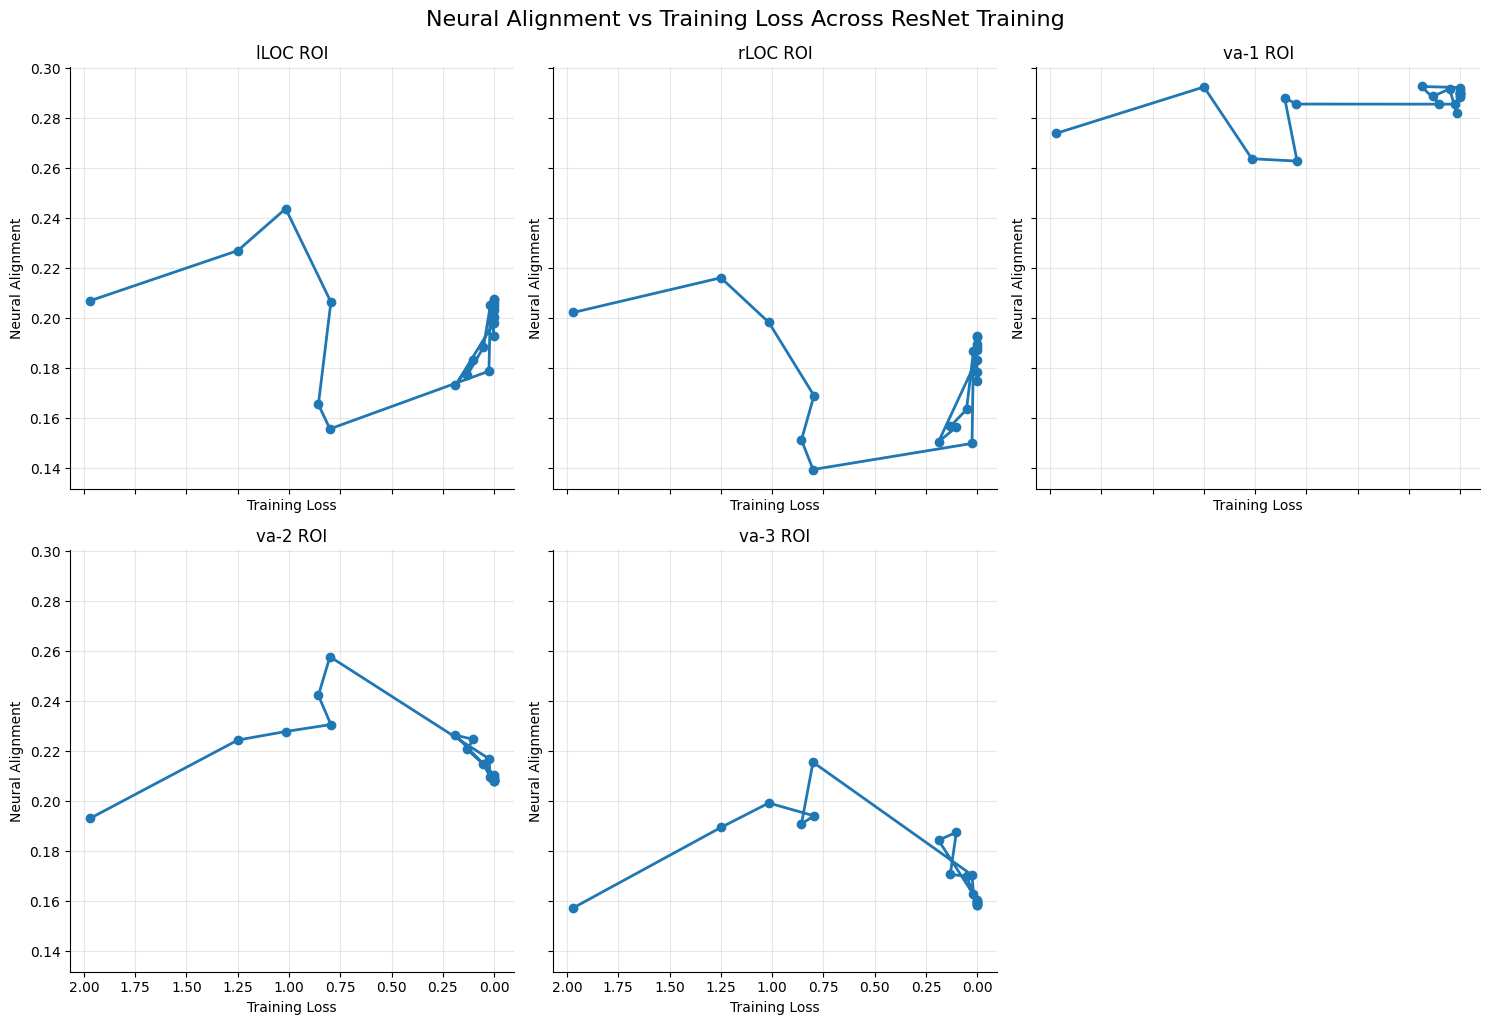

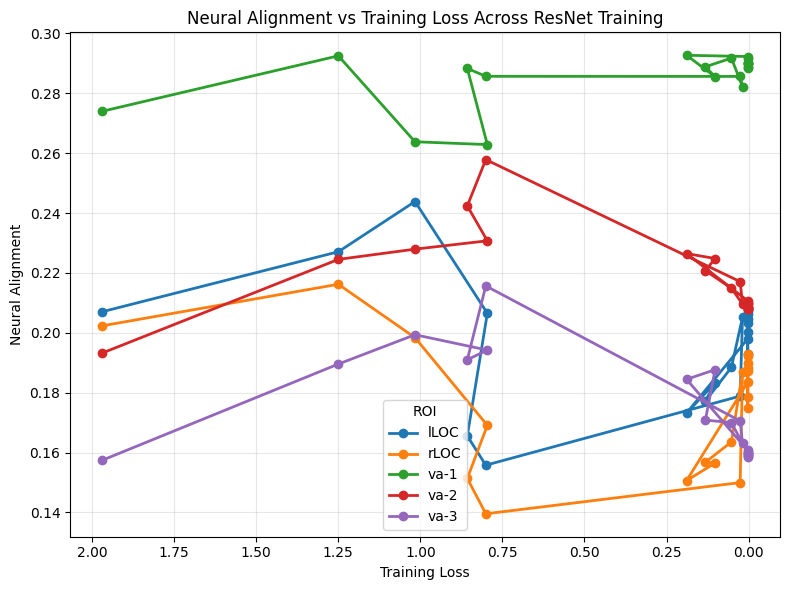

\n================================================================================
SUMMARY STATISTICS FOR ALL ROIs
\nlLOC ROI:
  Epochs analyzed: 20
  Correlation range: 0.1558 to 0.2439
  Mean correlation: 0.1967
  Std correlation: 0.0200
  Loss range: 0.0026 to 1.9684
  Best epoch: 30.0 (correlation: 0.2439, loss: 1.0162)
\nrLOC ROI:
  Epochs analyzed: 20
  Correlation range: 0.1396 to 0.2162
  Mean correlation: 0.1765
  Std correlation: 0.0203
  Loss range: 0.0026 to 1.9684
  Best epoch: 20.0 (correlation: 0.2162, loss: 1.2497)
\nva-1 ROI:
  Epochs analyzed: 20
  Correlation range: 0.2629 to 0.2927
  Mean correlation: 0.2857
  Std correlation: 0.0086
  Loss range: 0.0026 to 1.9684
  Best epoch: 120.0 (correlation: 0.2927, loss: 0.1889)
\nva-2 ROI:
  Epochs analyzed: 20
  Correlation range: 0.1933 to 0.2579
  Mean correlation: 0.2181
  Std correlation: 0.0141
  Loss range: 0.0026 to 1.9684
  Best epoch: 60.0 (correlation: 0.2579, loss: 0.8005)
\nva-3 ROI:
  Epochs analyzed: 20
  Corr

In [20]:
# Plot correlation vs loss for all ROIs, including all on one graph (adapted for ResNet)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the ResNet training results
resnet_res_df = pd.read_csv('resnet50_per_epoch_loss.csv')

# Filter for seed 5 (assuming we're using seed 5 for the analysis)
resnet_res_df = resnet_res_df[resnet_res_df['seed'] == 5]

# Group by epoch and take the mean loss (in case there are multiple entries per epoch)
loss_by_epoch = resnet_res_df.groupby('epoch')['loss'].mean().reset_index()

# Check if feature_reweighted_all_rois_results exists
if 'resnet_feature_reweighted_all_rois_results' in locals():
    # Prepare ROI data for plotting
    rois = sorted(resnet_feature_reweighted_all_rois_results.keys())
    n_rois = len(rois)
    
    # --- Individual subplots for each ROI ---
    if n_rois <= 3:
        fig, axes = plt.subplots(1, n_rois, figsize=(5*n_rois, 5), sharex=True, sharey=True)
        if n_rois == 1:
            axes = [axes]
    else:
        n_cols = (n_rois + 1) // 2
        fig, axes = plt.subplots(2, n_cols, figsize=(5*n_cols, 10), sharex=True, sharey=True)
        axes = axes.flatten()
    
    for i, roi in enumerate(rois):
        ax = axes[i]
        # Get correlation and epoch from results for this ROI
        epochs = sorted(resnet_feature_reweighted_all_rois_results[roi].keys(), key=lambda x: int(x))
        correlations = [resnet_feature_reweighted_all_rois_results[roi][epoch]['correlation'] for epoch in epochs]
        
        # Create DataFrame for this ROI
        cor_df = pd.DataFrame({
            'epoch': [int(e) for e in epochs],
            'correlation': correlations
        })
        
        # Join with loss data
        merged = pd.merge(cor_df, loss_by_epoch, left_on='epoch', right_on='epoch', how='inner')
        
        ax.plot(merged['loss'], merged['correlation'], marker='o', linewidth=2, markersize=6, label=roi)
        ax.set_xlabel('Training Loss')
        ax.set_ylabel('Neural Alignment')
        ax.set_title(f'{roi} ROI')
        ax.grid(True, alpha=0.3)
        ax.invert_xaxis()  # Invert x-axis so loss decreases from left to right
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Hide unused subplots if any
    for i in range(n_rois, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Neural Alignment vs Training Loss Across ResNet Training', y=1.02, fontsize=16)
    plt.show()
    
    # --- All ROIs on the same plot ---
    plt.figure(figsize=(8, 6))
    colors = plt.cm.tab10.colors if n_rois <= 10 else plt.cm.tab20.colors
    for i, roi in enumerate(rois):
        # Get correlation and epoch from results for this ROI
        epochs = sorted(resnet_feature_reweighted_all_rois_results[roi].keys(), key=lambda x: int(x))
        correlations = [resnet_feature_reweighted_all_rois_results[roi][epoch]['correlation'] for epoch in epochs]
        
        # Create DataFrame for this ROI
        cor_df = pd.DataFrame({
            'epoch': [int(e) for e in epochs],
            'correlation': correlations
        })
        
        # Join with loss data
        merged = pd.merge(cor_df, loss_by_epoch, left_on='epoch', right_on='epoch', how='inner')
        
        plt.plot(merged['loss'], merged['correlation'], marker='o', linewidth=2, markersize=6, label=roi, color=colors[i % len(colors)])
    
    plt.xlabel('Training Loss')
    plt.ylabel('Neural Alignment')
    plt.title('Neural Alignment vs Training Loss Across ResNet Training')
    plt.grid(True, alpha=0.3)
    plt.gca().invert_xaxis()  # Invert x-axis so loss decreases from left to right
    plt.legend(title='ROI')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for each ROI
    print("\\n" + "="*80)
    print("SUMMARY STATISTICS FOR ALL ROIs")
    print("="*80)
    
    for roi in sorted(resnet_feature_reweighted_all_rois_results.keys()):
        epochs = sorted(resnet_feature_reweighted_all_rois_results[roi].keys(), key=lambda x: int(x))
        correlations = [resnet_feature_reweighted_all_rois_results[roi][epoch]['correlation'] for epoch in epochs]
        
        # Create DataFrame for this ROI
        cor_df = pd.DataFrame({
            'epoch': [int(e) for e in epochs],
            'correlation': correlations
        })
        
        # Join with loss data
        merged = pd.merge(cor_df, loss_by_epoch, left_on='epoch', right_on='epoch', how='inner')
        
        print(f"\\n{roi} ROI:")
        print(f"  Epochs analyzed: {len(merged)}")
        print(f"  Correlation range: {min(merged['correlation']):.4f} to {max(merged['correlation']):.4f}")
        print(f"  Mean correlation: {np.mean(merged['correlation']):.4f}")
        print(f"  Std correlation: {np.std(merged['correlation']):.4f}")
        print(f"  Loss range: {min(merged['loss']):.4f} to {max(merged['loss']):.4f}")
        
        # Find best epoch
        best_epoch_idx = np.argmax(merged['correlation'])
        best_epoch = merged.iloc[best_epoch_idx]['epoch']
        best_correlation = merged.iloc[best_epoch_idx]['correlation']
        best_loss = merged.iloc[best_epoch_idx]['loss']
        print(f"  Best epoch: {best_epoch} (correlation: {best_correlation:.4f}, loss: {best_loss:.4f})")

else:
    print("feature_reweighted_all_rois_results not found. Please run the analysis first.")

# ViT on CIFAR-100 - Behavioral Alignment

# ViT on CIFAR-100 - Neural Alignment

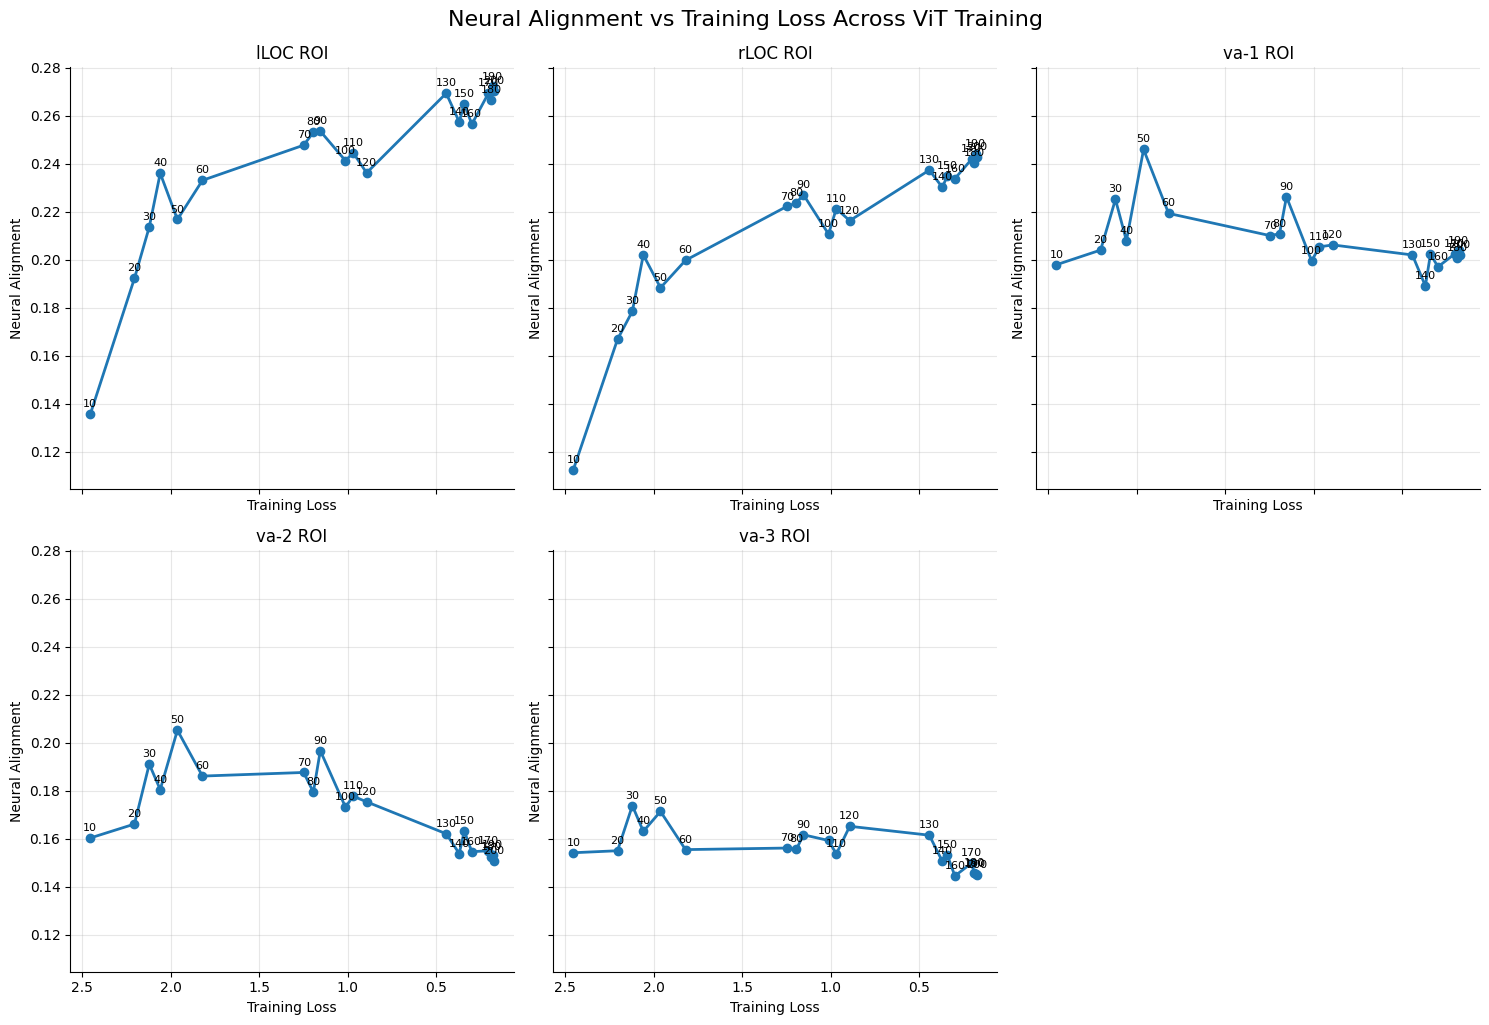

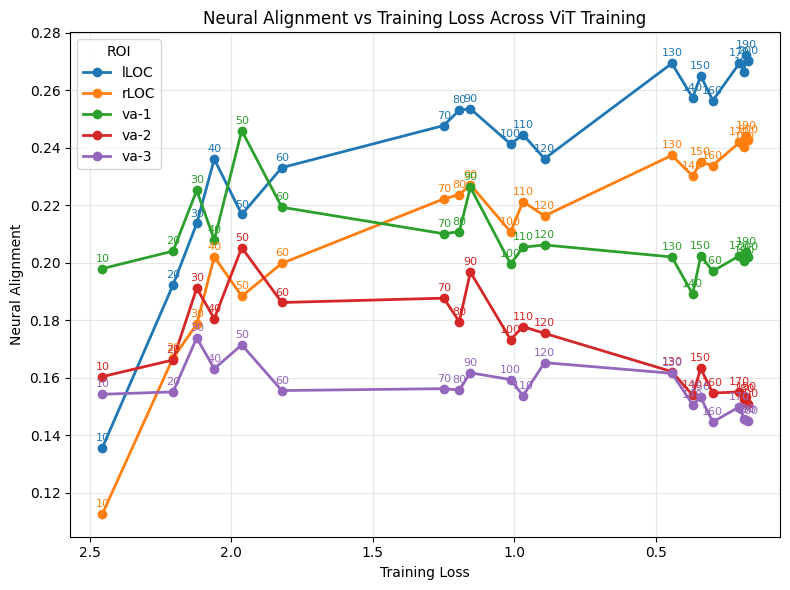

\n================================================================================
SUMMARY STATISTICS FOR ALL ROIs
\nlLOC ROI:
  Epochs analyzed: 20
  Correlation range: 0.1357 to 0.2722
  Mean correlation: 0.2415
  Std correlation: 0.0320
  Loss range: 0.1746 to 2.4548
  Best epoch: 190.0 (correlation: 0.2722, loss: 0.1801)
\nrLOC ROI:
  Epochs analyzed: 20
  Correlation range: 0.1126 to 0.2442
  Mean correlation: 0.2137
  Std correlation: 0.0316
  Loss range: 0.1746 to 2.4548
  Best epoch: 190.0 (correlation: 0.2442, loss: 0.1801)
\nva-1 ROI:
  Epochs analyzed: 20
  Correlation range: 0.1891 to 0.2460
  Mean correlation: 0.2079
  Std correlation: 0.0124
  Loss range: 0.1746 to 2.4548
  Best epoch: 50.0 (correlation: 0.2460, loss: 1.9624)
\nva-2 ROI:
  Epochs analyzed: 20
  Correlation range: 0.1509 to 0.2053
  Mean correlation: 0.1713
  Std correlation: 0.0160
  Loss range: 0.1746 to 2.4548
  Best epoch: 50.0 (correlation: 0.2053, loss: 1.9624)
\nva-3 ROI:
  Epochs analyzed: 20
  Cor

In [29]:
# Plot correlation vs loss for all ROIs, including all on one graph (adapted for ViT)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the ViT training results
vit_res_df = pd.read_csv('vit_b_16_per_epoch_loss.csv')

# Filter for seed 0 (assuming we're using seed 0 for the analysis)
vit_res_df = vit_res_df[vit_res_df['seed'] == 3]

# Group by epoch and take the mean loss (in case there are multiple entries per epoch)
loss_by_epoch = vit_res_df.groupby('epoch')['loss'].mean().reset_index()

# Check if feature_reweighted_all_rois_results exists
if 'vit_feature_reweighted_all_rois_results' in locals():
    # Prepare ROI data for plotting
    rois = sorted(vit_feature_reweighted_all_rois_results.keys())
    n_rois = len(rois)
    
    # --- Individual subplots for each ROI ---
    if n_rois <= 3:
        fig, axes = plt.subplots(1, n_rois, figsize=(5*n_rois, 5), sharex=True, sharey=True)
        if n_rois == 1:
            axes = [axes]
    else:
        n_cols = (n_rois + 1) // 2
        fig, axes = plt.subplots(2, n_cols, figsize=(5*n_cols, 10), sharex=True, sharey=True)
        axes = axes.flatten()
    
    for i, roi in enumerate(rois):
        ax = axes[i]
        # Get correlation and epoch from results for this ROI
        epochs = sorted(vit_feature_reweighted_all_rois_results[roi].keys(), key=lambda x: int(x))
        correlations = [vit_feature_reweighted_all_rois_results[roi][epoch]['correlation'] for epoch in epochs]
        
        # Create DataFrame for this ROI
        cor_df = pd.DataFrame({
            'epoch': [int(e) for e in epochs],
            'correlation': correlations
        })
        
        # Join with loss data
        merged = pd.merge(cor_df, loss_by_epoch, left_on='epoch', right_on='epoch', how='inner')
        
        ax.plot(merged['loss'], merged['correlation'], marker='o', linewidth=2, markersize=6, label=roi)
        # Label each point with the epoch number
        for j, row in merged.iterrows():
            ax.annotate(str(int(row['epoch'])), (row['loss'], row['correlation']),
                        textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='black')
        ax.set_xlabel('Training Loss')
        ax.set_ylabel('Neural Alignment')
        ax.set_title(f'{roi} ROI')
        ax.grid(True, alpha=0.3)
        ax.invert_xaxis()  # Invert x-axis so loss decreases from left to right
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Hide unused subplots if any
    for i in range(n_rois, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Neural Alignment vs Training Loss Across ViT Training', y=1.02, fontsize=16)
    plt.show()
    
    # --- All ROIs on the same plot ---
    plt.figure(figsize=(8, 6))
    colors = plt.cm.tab10.colors if n_rois <= 10 else plt.cm.tab20.colors
    for i, roi in enumerate(rois):
        # Get correlation and epoch from results for this ROI
        epochs = sorted(vit_feature_reweighted_all_rois_results[roi].keys(), key=lambda x: int(x))
        correlations = [vit_feature_reweighted_all_rois_results[roi][epoch]['correlation'] for epoch in epochs]
        
        # Create DataFrame for this ROI
        cor_df = pd.DataFrame({
            'epoch': [int(e) for e in epochs],
            'correlation': correlations
        })
        
        # Join with loss data
        merged = pd.merge(cor_df, loss_by_epoch, left_on='epoch', right_on='epoch', how='inner')
        
        plt.plot(merged['loss'], merged['correlation'], marker='o', linewidth=2, markersize=6, label=roi, color=colors[i % len(colors)])
        # Label each point with the epoch number
        for j, row in merged.iterrows():
            plt.annotate(str(int(row['epoch'])), (row['loss'], row['correlation']),
                         textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color=colors[i % len(colors)])
    
    plt.xlabel('Training Loss')
    plt.ylabel('Neural Alignment')
    plt.title('Neural Alignment vs Training Loss Across ViT Training')
    plt.grid(True, alpha=0.3)
    plt.gca().invert_xaxis()  # Invert x-axis so loss decreases from left to right
    plt.legend(title='ROI')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for each ROI
    print("\\n" + "="*80)
    print("SUMMARY STATISTICS FOR ALL ROIs")
    print("="*80)
    
    for roi in sorted(vit_feature_reweighted_all_rois_results.keys()):
        epochs = sorted(vit_feature_reweighted_all_rois_results[roi].keys(), key=lambda x: int(x))
        correlations = [vit_feature_reweighted_all_rois_results[roi][epoch]['correlation'] for epoch in epochs]
        
        # Create DataFrame for this ROI
        cor_df = pd.DataFrame({
            'epoch': [int(e) for e in epochs],
            'correlation': correlations
        })
        
        # Join with loss data
        merged = pd.merge(cor_df, loss_by_epoch, left_on='epoch', right_on='epoch', how='inner')
        
        print(f"\\n{roi} ROI:")
        print(f"  Epochs analyzed: {len(merged)}")
        print(f"  Correlation range: {min(merged['correlation']):.4f} to {max(merged['correlation']):.4f}")
        print(f"  Mean correlation: {np.mean(merged['correlation']):.4f}")
        print(f"  Std correlation: {np.std(merged['correlation']):.4f}")
        print(f"  Loss range: {min(merged['loss']):.4f} to {max(merged['loss']):.4f}")
        
        # Find best epoch
        best_epoch_idx = np.argmax(merged['correlation'])
        best_epoch = merged.iloc[best_epoch_idx]['epoch']
        best_correlation = merged.iloc[best_epoch_idx]['correlation']
        best_loss = merged.iloc[best_epoch_idx]['loss']
        print(f"  Best epoch: {best_epoch} (correlation: {best_correlation:.4f}, loss: {best_loss:.4f})")

else:
    print("vit_feature_reweighted_all_rois_results not found. Please run the analysis first.")

Training epochs: 20
Initial loss: 2.4548
Final loss: 0.1746
Loss reduction: 2.2802
Min loss: 0.1746 at epoch 200


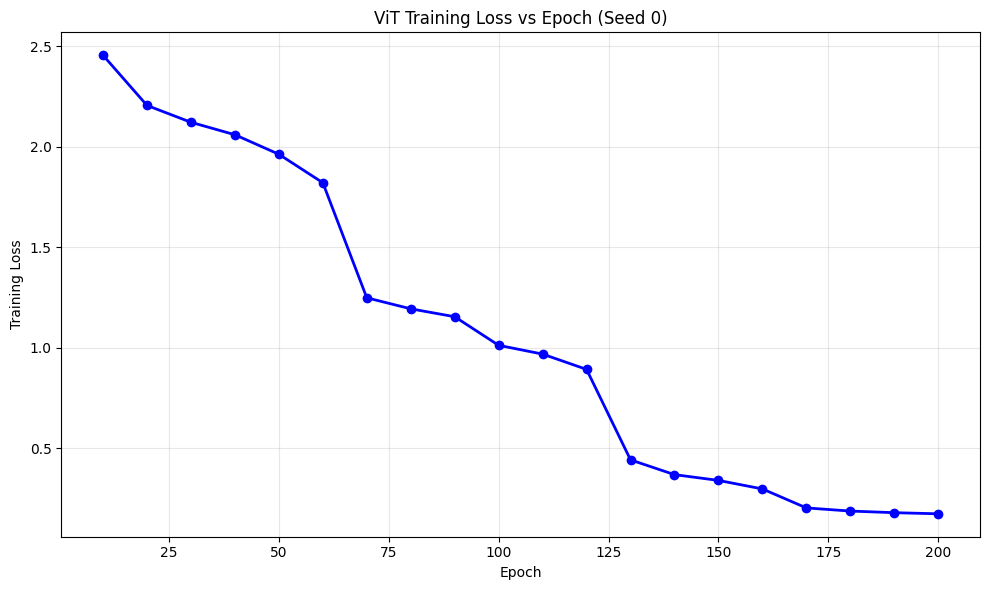

In [30]:
# Plot training loss vs epoch for ViT
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the ViT training results
vit_res_df = pd.read_csv('vit_b_16_per_epoch_loss.csv')

# Filter for seed 0 (assuming we're using seed 0 for the analysis)
vit_res_df_seed0 = vit_res_df[vit_res_df['seed'] == 3]

# Group by epoch and take the mean loss (in case there are multiple entries per epoch)
loss_by_epoch = vit_res_df_seed0.groupby('epoch')['loss'].mean().reset_index()

# Sort by epoch for proper plotting
loss_by_epoch = loss_by_epoch.sort_values('epoch')

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(loss_by_epoch['epoch'], loss_by_epoch['loss'], marker='o', linewidth=2, markersize=6, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('ViT Training Loss vs Epoch (Seed 0)')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add some statistics
print(f"Training epochs: {len(loss_by_epoch)}")
print(f"Initial loss: {loss_by_epoch.iloc[0]['loss']:.4f}")
print(f"Final loss: {loss_by_epoch.iloc[-1]['loss']:.4f}")
print(f"Loss reduction: {loss_by_epoch.iloc[0]['loss'] - loss_by_epoch.iloc[-1]['loss']:.4f}")
print(f"Min loss: {loss_by_epoch['loss'].min():.4f} at epoch {loss_by_epoch.loc[loss_by_epoch['loss'].idxmin(), 'epoch']}")

# Baseline CLIP Behavioral Alignment REI Calculation

In [75]:
# load in clip_res.csv
clip_res = pd.read_csv('clip_res.csv')

def calculate_elasticity_midpoint(q1, q2, p1, p2):
    """
    Calculates elasticity using the midpoint method.

    Args:
        q1 (float): Initial loss.
        q2 (float): New loss.
        p1 (float): Initial rho.
        p2 (float): New rho.

    Returns:
        float: The elasticity value.
    """
    percent_change_quantity = ((q2 - q1) / ((q1 + q2) / 2)) * 100
    percent_change_price = ((p2 - p1) / ((p1 + p2) / 2)) * 100

    if percent_change_price == 0:
        return float('inf')  # Handle perfectly inelastic case
    else:
        return percent_change_quantity / percent_change_price

# create a new dataframe called clip_rei_calc
clip_rei_calc = pd.DataFrame()
clip_rei_calc['epoch'] = clip_res['epoch']

# create a new column called loss_change that calculates the change in val_infonce_loss between each epoch of clip_res
clip_rei_calc['loss_change'] = clip_res['val_infonce_loss'].diff()

# create a new column called rei that calculates the REI for each epoch of clip_res
clip_rei_calc['rei'] = clip_rei_calc['loss_change'] * clip_res['spearman_rho']

# plot the rei vs epoch
plt.figure(figsize=(10, 6))
plt.plot(clip_rei_calc['epoch'], clip_rei_calc['rei'], marker='o', linewidth=2, markersize=6, color='blue')
# Example usage
initial_quantity = 100
new_quantity = 90
initial_price = 10
new_price = 12

elasticity = calculate_elasticity_midpoint(initial_quantity, new_quantity, initial_price, new_price)
print(f"Elasticity (Midpoint Method): {elasticity:.2f}")

KeyError: 'spearman_rho'

{'centers': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), 'rho': array([-0.5, -0.5, -1. , -0.5, -0.5, -1. , -1. , -0.5, -0.5,  0.5,  0.5,
       -1. , -1. , -0.5,  1. , -0.5,  0.5,  1. , -0.5, -0.5,  0.5, -0.5,
        1. , -0.5, -0.5, -0.5, -0.5, -1. ,  0.5,  1. ]), 'rho_p': array([0.66666667, 0.66666667, 0.        , 0.66666667, 0.66666667,
       0.        , 0.        , 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.        , 0.        , 0.66666667, 0.        ,
       0.66666667, 0.66666667, 0.        , 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.        , 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.        , 0.66666667, 0.        ]), 'slope': array([-0.12400489, -0.05586693, -0.12136568, -0.0736151 , -0.00943101,
       -0.17497629, -0.34207382, -0.21154841, -0.12264451,  0.03554525,
        0.13677168, -0.2835345 , -0.14297543, -0.02794003,  0.19477913,
    

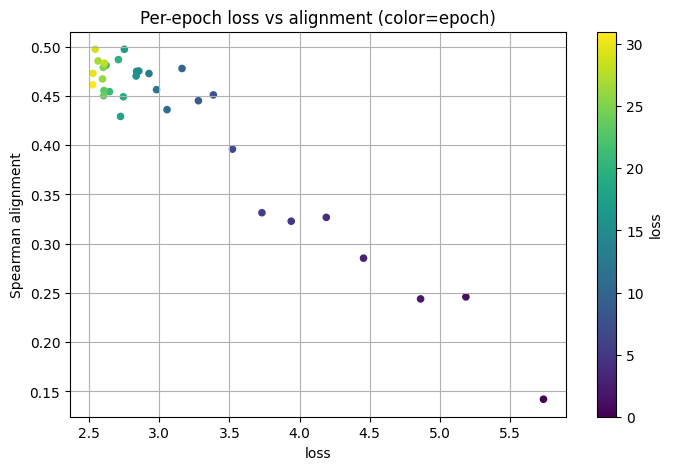

In [88]:
from scipy.stats import spearmanr
from scipy.stats import linregress

def sliding_window_stats(loss, align, window_size=32, step=1):
    N = len(loss)
    centers = []
    rho_vals = []
    slope_vals = []
    intercept_vals = []
    pvals = []
    counts = []

    for start in range(0, N - window_size + 1, step):
        stop = start + window_size
        x = loss[start:stop]
        y = align[start:stop]

        # If you have ties or many identical values, spearmanr still works.
        rho, p = spearmanr(x, y)           # Spearman correlation within window
        # Fit linear trend align ~ loss to get slope
        lr = linregress(x, y)             # returns slope, intercept, rvalue, pvalue, stderr

        centers.append(start + window_size // 2)
        rho_vals.append(rho)
        pvals.append(p)
        slope_vals.append(lr.slope)
        intercept_vals.append(lr.intercept)
        counts.append(len(x))

    return {
        'centers': np.array(centers),
        'rho': np.array(rho_vals),
        'rho_p': np.array(pvals),
        'slope': np.array(slope_vals),
        'intercept': np.array(intercept_vals),
        'counts': np.array(counts)
    }


window_size = 3
step = 1
#res = sliding_window_stats(loss, align, window_size=window_size, step=step)


# load in clip_res.csv
clip_res = pd.read_csv('clip_res.csv')

rei_calc = sliding_window_stats(clip_res['val_infonce_loss'], clip_res['rsa_score'], window_size=window_size, step=step)


print(rei_calc)


# return the slope of the rei_calc dataframe
rei_calc['slope']

# Plot 1: raw per-epoch scatter colored by epoch + window centers
plt.figure(figsize=(8,5))
sc = plt.scatter(clip_res['val_infonce_loss'], clip_res['rsa_score'], c=np.arange(len(clip_res['val_infonce_loss'])), cmap='viridis', s=20)
plt.colorbar(sc, label='loss')
plt.xlabel('loss')
plt.ylabel('Spearman alignment')
plt.title('Per-epoch loss vs alignment (color=epoch)')
plt.grid(True)
plt.show()

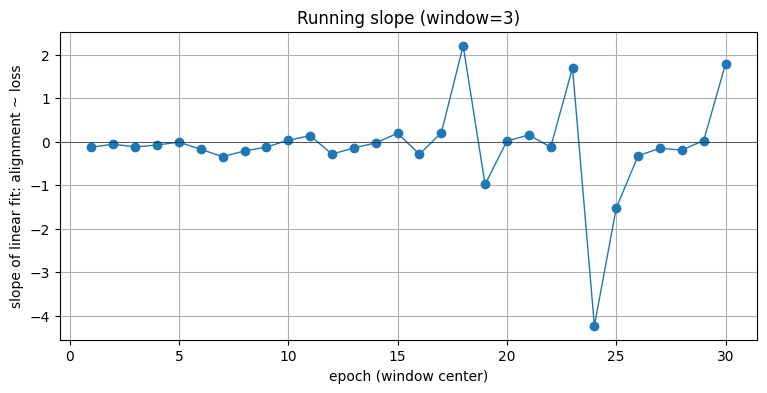

In [90]:
# Plot 3: running slope of align ~ loss
plt.figure(figsize=(9,4))
plt.plot(rei_calc['centers'], rei_calc['slope'], marker='o', lw=1)
plt.axhline(0, color='k', lw=0.6, alpha=0.6)
plt.xlabel('epoch (window center)')
plt.ylabel('slope of linear fit: alignment ~ loss')
plt.title(f'Running slope (window={window_size})')
plt.grid(True)
plt.show()

In [104]:
def sliding_elasticity(x, y, window_size, step=1, method='log_reg', eps=1e-8):
    """
    Compute elasticity of y w.r.t x in sliding windows.

    Args:
        x (1D array): independent variable (loss), length T
        y (1D array): dependent variable (Spearman), length T
        window_size (int): number of points in each window
        step (int): step between window starts
        method (str): one of ['log_reg', 'lin_scaled', 'arc', 'finite_diff']
        eps (float): small offset to ensure positive when using log_reg

    Returns:
        centers (list): center index of each window
        elast (list): elasticity per window (NaN if invalid)
    """
    n = len(x)
    centers = []
    elast = []
    for start in range(0, n - window_size + 1, step):
        end = start + window_size
        xs = np.array(x[start:end])
        ys = np.array(y[start:end])
        cx = xs.mean()
        cy = ys.mean()
        centers.append(start + (window_size-1)/2.0)

        if method == 'log_reg':
            # make positive
            xs_p = xs + eps - xs.min() if xs.min() <= 0 else xs + eps
            ys_p = ys + eps - ys.min() if ys.min() <= 0 else ys + eps
            lx = np.log(xs_p)
            ly = np.log(ys_p)
            slope, intercept, r, p, se = stats.linregress(lx, ly)
            elast.append(slope)  # slope is elasticity
        elif method == 'lin_scaled':
            slope, intercept, r, p, se = stats.linregress(xs, ys)
            if np.isclose(cy, 0.0):
                elast.append(np.nan)
            else:
                elast.append(slope * (cx / cy))
        elif method == 'arc':
            x1, x2 = xs[0], xs[-1]
            y1, y2 = ys[0], ys[-1]
            xbar = (x1 + x2) / 2.0
            ybar = (y1 + y2) / 2.0
            dx = x2 - x1
            dy = y2 - y1
            if np.isclose(dx,0) or np.isclose(xbar,0) or np.isclose(ybar,0):
                elast.append(np.nan)
            else:
                elast.append( (dy / ybar) / (dx / xbar) )
        elif method == 'finite_diff':
            x1, x2 = xs[0], xs[-1]
            y1, y2 = ys[0], ys[-1]
            dx = x2 - x1
            dy = y2 - y1
            if np.isclose(dx,0) or np.isclose(x1,0) or np.isclose(y1,0):
                elast.append(np.nan)
            else:
                elast.append( (dy / y1) / (dx / x1) )
        else:
            raise ValueError("Unknown method")
    return np.array(centers), np.array(elast)


centers, elast = sliding_elasticity(clip_res['val_infonce_loss'], clip_res['rsa_score'], window_size=5, step=step, method='arc')

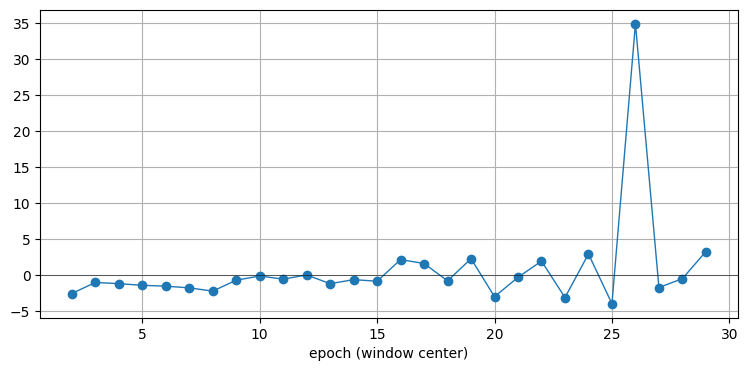

In [105]:

# Plot 3: running slope of align ~ loss
plt.figure(figsize=(9,4))
plt.plot(centers, elast, marker='o', lw=1)
plt.axhline(0, color='k', lw=0.6, alpha=0.6)
plt.xlabel('epoch (window center)')
plt.grid(True)
plt.show()


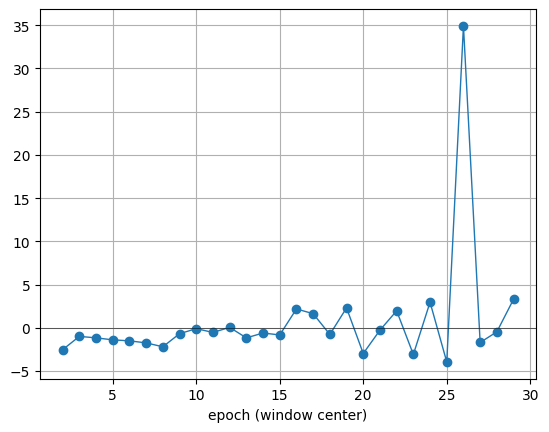

In [111]:
def sliding_midpoint_elasticity(x, y, window_size, step=1):
    """
    Compute arc (midpoint) elasticity of y w.r.t x in sliding windows.

    Args:
        x (array-like): independent variable (e.g., loss)
        y (array-like): dependent variable (e.g., Spearman correlation)
        window_size (int): number of points in each window
        step (int): stride between window starts

    Returns:
        centers (array): window center indices
        elasticity (array): arc elasticity per window
    """
    x, y = np.array(x), np.array(y)
    n = len(x)
    centers, elasticity = [], []

    for start in range(0, n - window_size + 1, step):
        end = start + window_size
        x1, x2 = x[start], x[end-1]
        y1, y2 = y[start], y[end-1]

        dx, dy = x2 - x1, y2 - y1
        xbar, ybar = (x1 + x2) / 2, (y1 + y2) / 2

        if np.isclose(dx,0) or np.isclose(xbar,0) or np.isclose(ybar,0):
            e = np.nan
        else:
            e = (dy / ybar) / (dx / xbar)

        centers.append(start + (window_size-1)/2)
        elasticity.append(e)

    return np.array(centers), np.array(elasticity)


centers, elast = sliding_midpoint_elasticity(clip_res['val_infonce_loss'], clip_res['rsa_score'], window_size=5, step=1)

plt.plot(centers, elast, marker='o', lw=1)
plt.axhline(0, color='k', lw=0.6, alpha=0.6)
plt.xlabel('epoch (window center)')
plt.grid(True)
plt.show()